Version notes: Include MVA

Prerequisites: Create single category combine cards with the RunCombine_singleCategory.ipynb

In [1]:
use_real_data = False
blinded_fit = False

runCombine = True
runBias = False
runFitDiagnostics = True
runImpacts = True

version = 'v2'
version_singleCard = 'v13'

In [2]:
card_name = version+'combination'
if not use_real_data: card_name += '_Asimov'
if blinded_fit: 
    card_name += '_blinded'

SM_RDst = 0.295

# Import

In [3]:
import sys, os, pickle, time
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import commands
from prettytable import PrettyTable
import json, yaml
from IPython.display import IFrame, Image, display

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from array import array

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from gridVarQ2Plot import plot_gridVarQ2, plot_SingleCategory, getControlXtitle, getControlSideText
from progressBar import ProgressBar
from combine_utilities import getUncertaintyFromLimitTree, dumpDiffNuisances, stringJubCustomizationCaltechT2

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

if use_real_data:
    CMS_lumi.extraText = "     Preliminary"
else:
    CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


# Load the cards

In [5]:
processOrder = ['tau', 'mu', 'DstPip','DstPi0','DstPipPi0','DstPipPim','DstPi0Pi0','DstmDsp','DstmD0','DstmDp','BpDstmHc','BmDstmHc','antiB0DstmHc']

In [6]:
categoriesList = ['low', 'mid', 'high']

In [7]:
cardLoc_sCat = {}
card_sCat = {}
for c in categoriesList:
    auxC = version_singleCard + c
    if not use_real_data: auxC += '_Asimov'
    if blinded_fit: auxC += '_blinded'
    cardLoc_sCat[c] = 'cards/' + auxC + '.txt'
    with open(cardLoc_sCat[c], 'r') as f:
        card_sCat[c] = f.read()

In [8]:
expectedLumi = {'low':6.4, 'mid':20.7, 'high':26.4} #fb^-1
binning = {'q2': array('d', [-2, 2.5, 6, 9.4, 12])}

# Create combination card

In [9]:
card_location = 'cards/' + card_name + '.txt'
cmd = 'cd cards; '
cmd += 'combineCards.py'
for c in categoriesList:
    cmd += ' {}={}'.format(c, cardLoc_sCat[c].replace('cards/', ''))
cmd += ' > ' + card_name + '.txt'
print cmd
if os.system(cmd): raise

cmd = cmd.replace('.txt', '_fitRegionsOnly.txt')
print cmd
if os.system(cmd): raise

cd cards; combineCards.py low=v13low_Asimov.txt mid=v13mid_Asimov.txt high=v13high_Asimov.txt > v2combination_Asimov.txt
cd cards; combineCards.py low=v13low_Asimov_fitRegionsOnly.txt mid=v13mid_Asimov_fitRegionsOnly.txt high=v13high_Asimov_fitRegionsOnly.txt > v2combination_Asimov_fitRegionsOnly.txt


TypeError: exceptions must be old-style classes or derived from BaseException, not NoneType

Traceback (most recent call last):
  File "/storage/user/ocerri/work/CMSSW_10_2_13/bin/slc7_amd64_gcc700/combineCards.py", line 50, in <module>
    file = open(fname, "r")
IOError: [Errno 2] No such file or directory: 'v13low_Asimov_fitRegionsOnly.txt'


In [10]:
with open(card_location) as f:
    print f.read()

Combination of low=v13low_Asimov.txt  mid=v13mid_Asimov.txt  high=v13high_Asimov.txt
imax 54 number of bins
jmax 12 number of processes minus 1
kmax 30 number of nuisance parameters
----------------------------------------------------------------------------------------------------------------------------------
shapes *                     high_AddTk_m_mHad     /storage/user/ocerri/BPhysics/data/_root/histos4combine/v13high_Asimov_AddTk_m_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes *                     high_AddTk_mm_mHad    /storage/user/ocerri/BPhysics/data/_root/histos4combine/v13high_Asimov_AddTk_mm_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes *                     high_AddTk_p_mHad     /storage/user/ocerri/BPhysics/data/_root/histos4combine/v13high_Asimov_AddTk_p_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
shapes *                     high_AddTk_pm_mHad    /storage/user/ocerri/BPhysics/data/_root/histos4combine/v13high_Asimov_AddTk_pm_mHad.root $PROCESS $PROCESS__$SYSTEMATIC
s

In [14]:
outdir = 'results/' + card_name
if not os.path.isdir(outdir):
    os.system('mkdir -p ' + outdir + '/fig')

## Create the workspace

In [11]:
cmd = 'text2workspace.py ' + card_location 
cmd += ' -o ' + card_location.replace('.txt', '.root')
cmd += ' --no-b-only'
cmd += ' --verbose 1'
cmd += ' --channel-masks'

status, output = commands.getstatusoutput(cmd)
if status: 
    print output
    raise
else:
    text_file = open(card_location.replace('.txt', '_text2workspace.out'), "w")
    text_file.write(output)
    text_file.close()
    
cmd = cmd.replace('.txt', '_fitRegionsOnly.txt').replace('.root', '_fitRegionsOnly.root')
print cmd
# if os.system(cmd): raise

text2workspace.py cards/v2combination_Asimov_fitRegionsOnly.txt -o cards/v2combination_Asimov_fitRegionsOnly.root --no-b-only --verbose 1 --channel-masks


# Pre-fit plots

Load the histograms

In [12]:
histo = {}
fAux = {}
for c in categoriesList:
    histo[c] = {}
    fAux[c] = {}
    for line in card_sCat[c].split(60*'-'+'\n')[1][:-1].split('\n'):
        line = line.split(' ')
        k = line[2]
        histo[c][k] = {}
        loc = line[3]
        fAux[c][k] = rt.TFile.Open(loc, 'READ')
        for o in fAux[c][k].GetListOfKeys():
            n = o.GetName()
            if '__' in n:
                continue
            histo[c][k][n.replace('_obs', '')] = fAux[c][k].Get(n).Clone()
scale_dic = {'tau': SM_RDst}

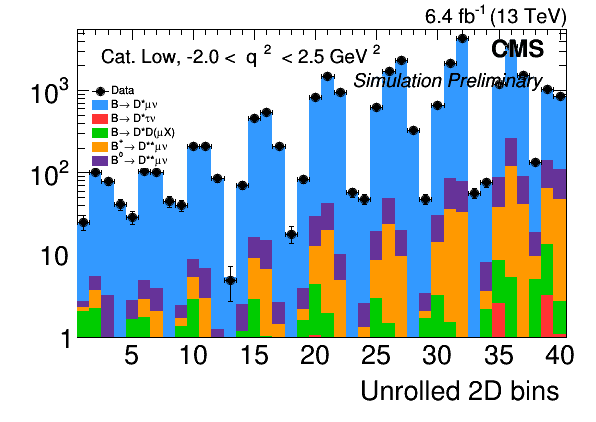

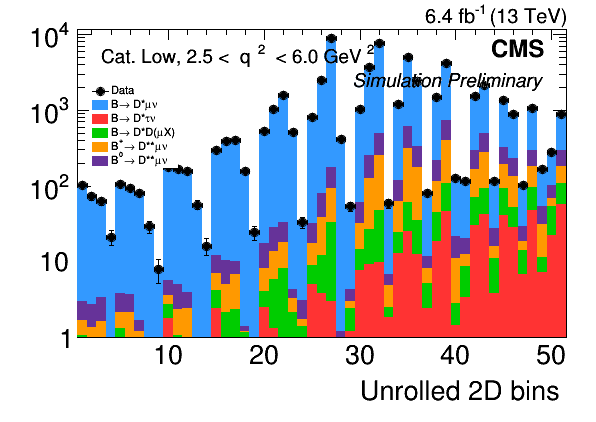

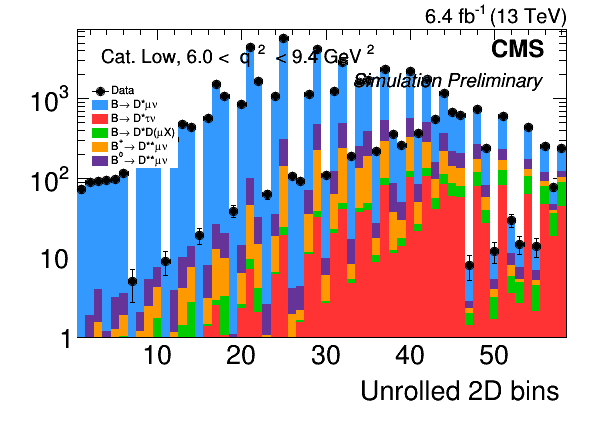

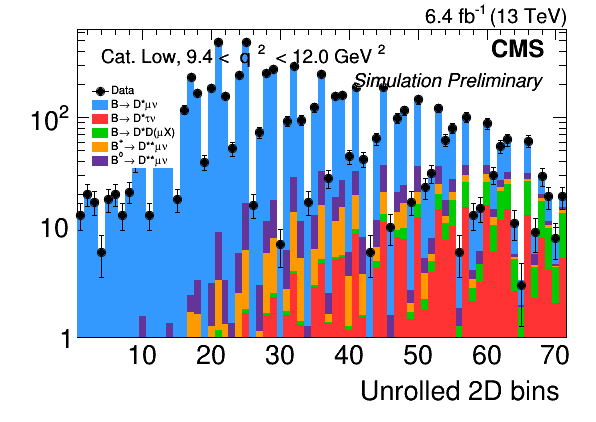

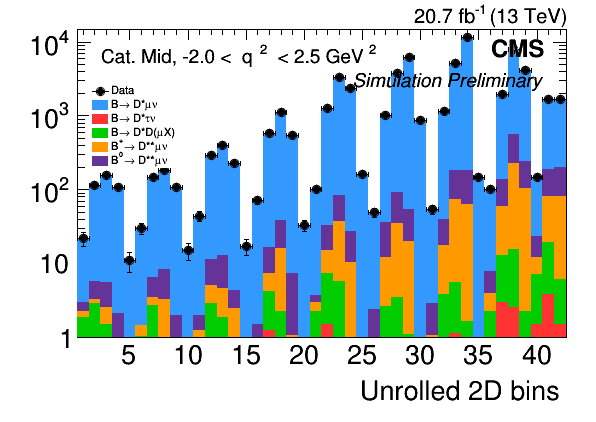

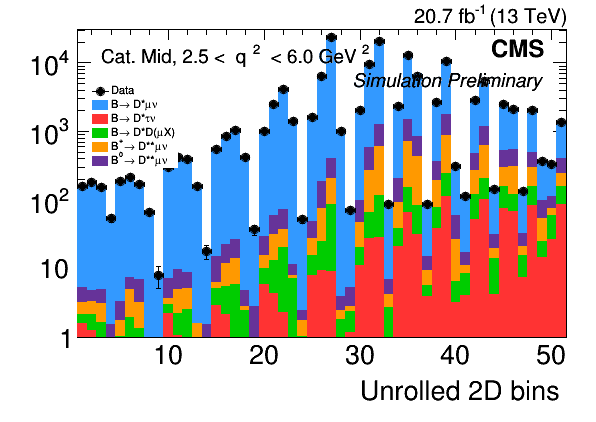

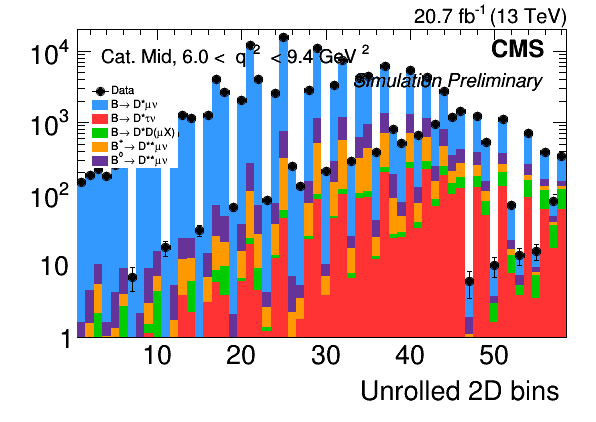

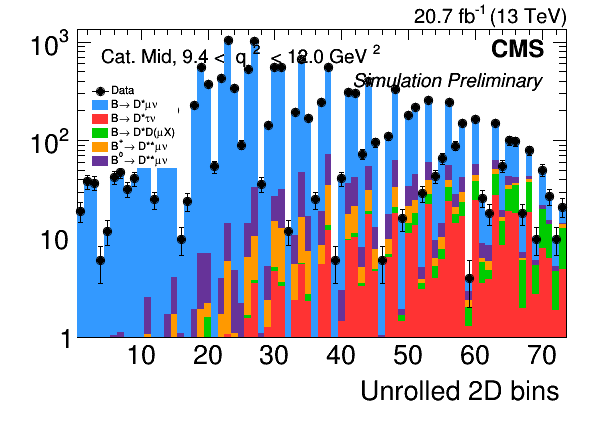

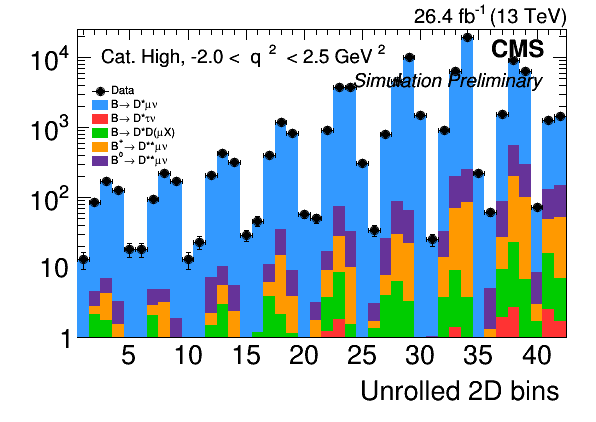

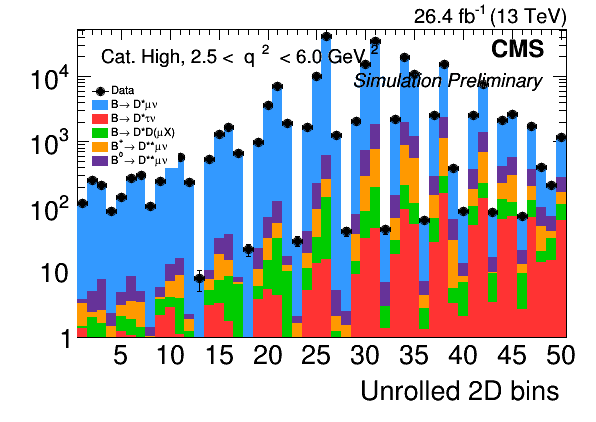

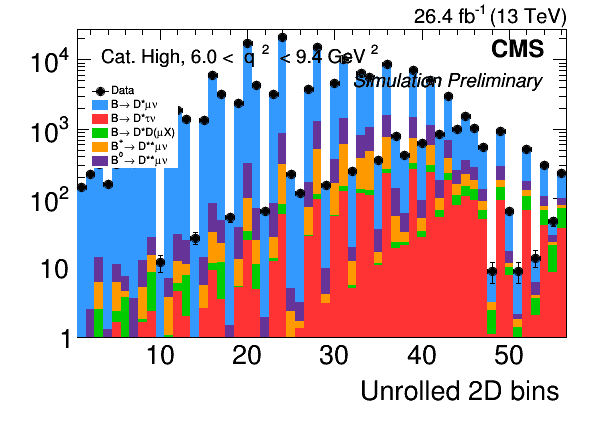

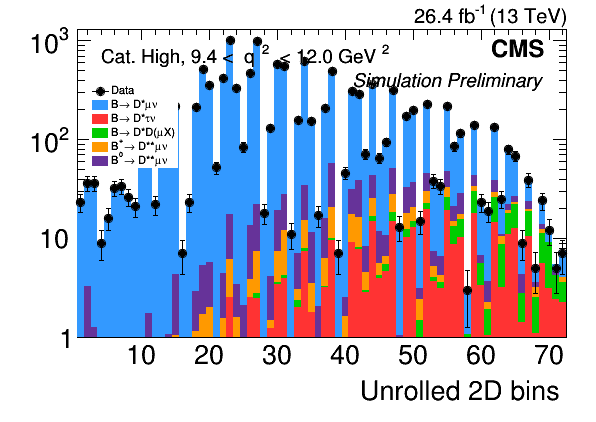

In [15]:
cUnrolledPre = {}
for c in categoriesList:
    CMS_lumi.integrated_lumi = expectedLumi[c]
    cUnrolledPre[c] = []
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        nameU = 'Unrolled_q2bin'+str(i_q2)
        histo[c][nameU]['data'].GetXaxis().SetTitle('Unrolled 2D bins')
        histo[c][nameU]['data'].GetYaxis().SetTitle('Events')
        cUnrolledPre[c].append(plot_SingleCategory(CMS_lumi, histo[c][nameU], scale_dic=scale_dic,
            addText='Cat. '+c.capitalize() + ', {:.1f} <  q^{{2}}  < {:.1f} GeV^{{2}}'.format(q2_l, q2_h), 
            logy=True, legBkg=True,
            procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
            min_y=1, 
            tag='Unrolled_q2bin'+str(i_q2)+c, 
            legLoc=[0.15, 0.6, 0.3, 0.8],
            maskData = blinded_fit and (False if i_q2 < 2 else True)
        ))
        cUnrolledPre[c][i_q2].SaveAs(outdir + '/fig/preFit_Unrolled_q2bin{}_{}.png'.format(i_q2, c))

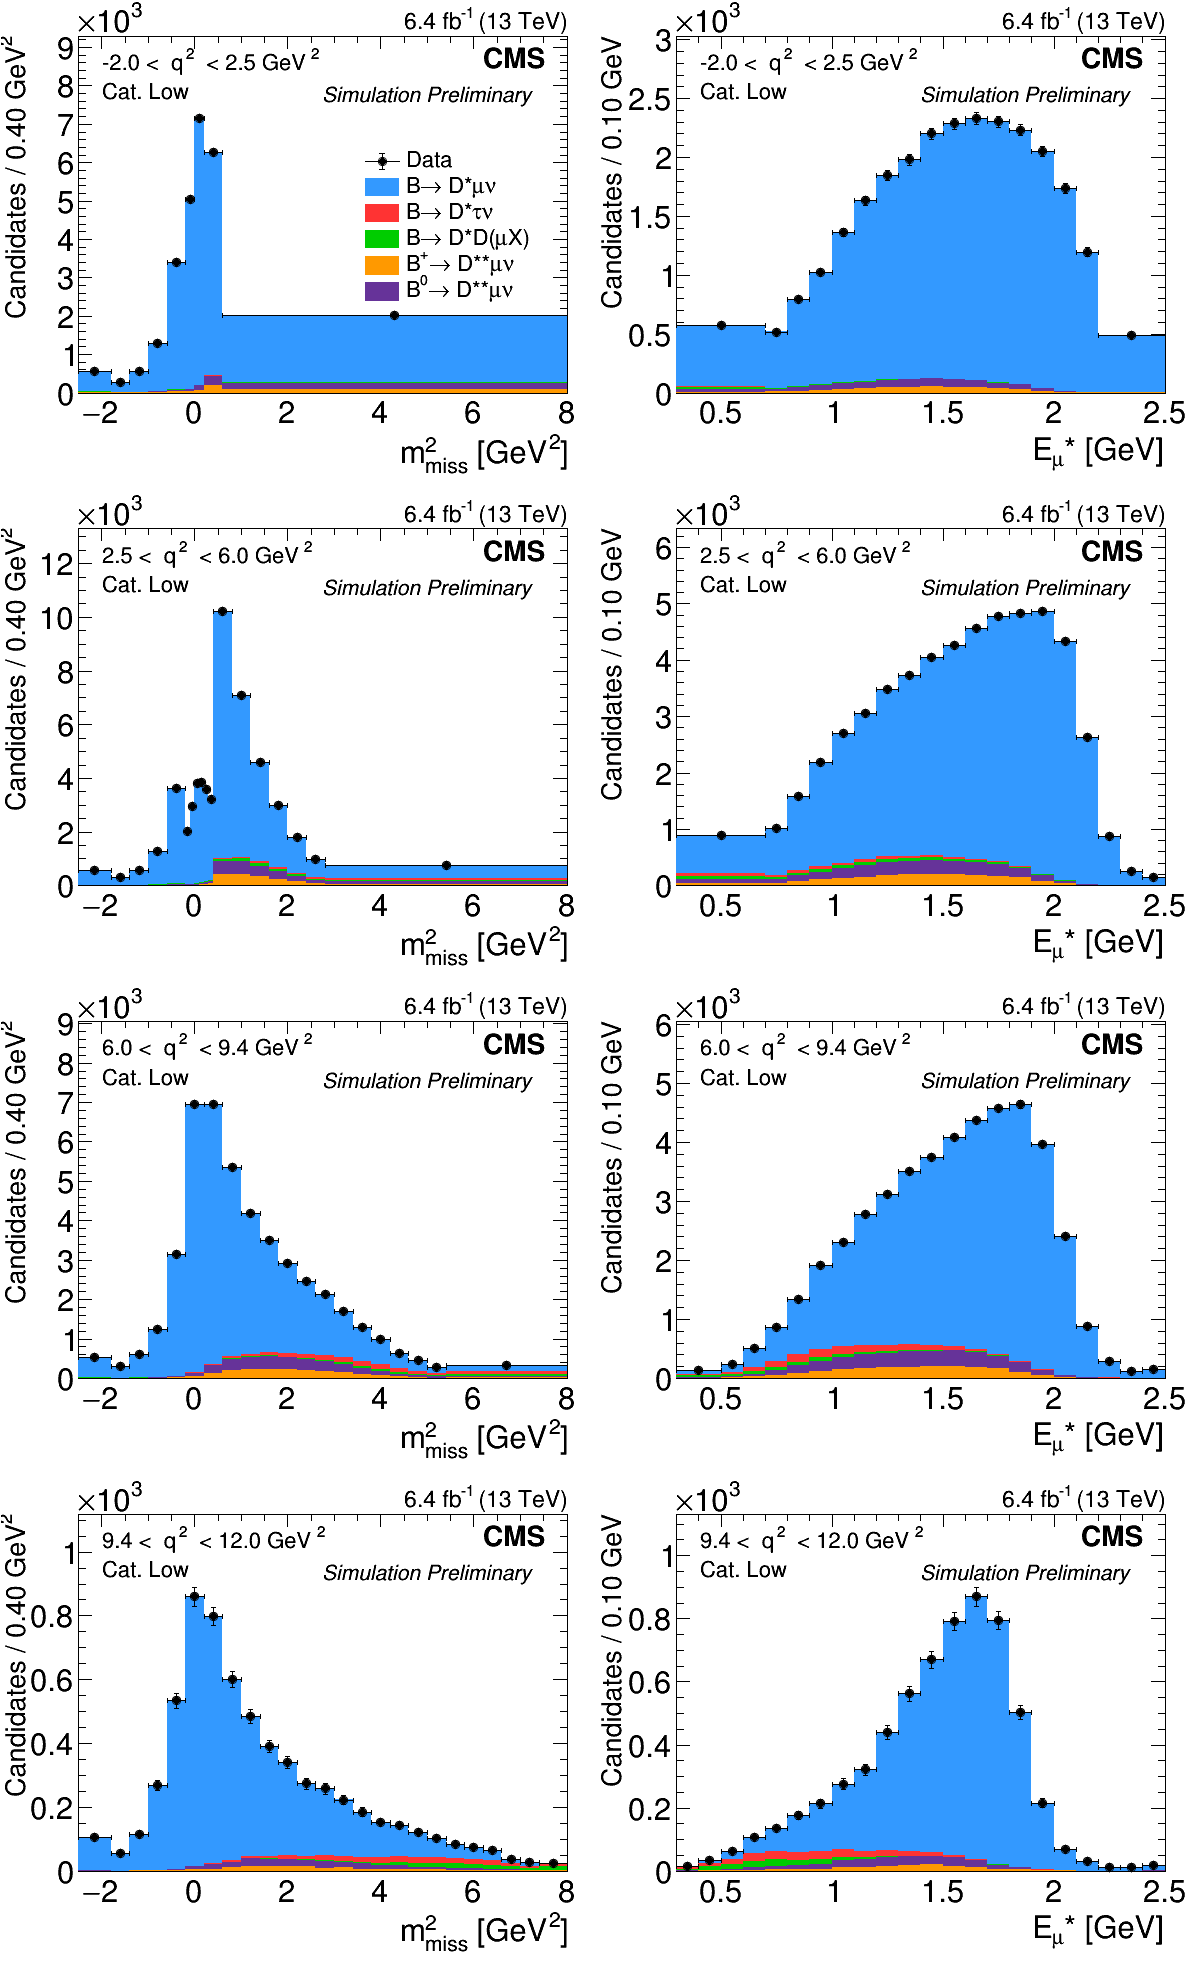

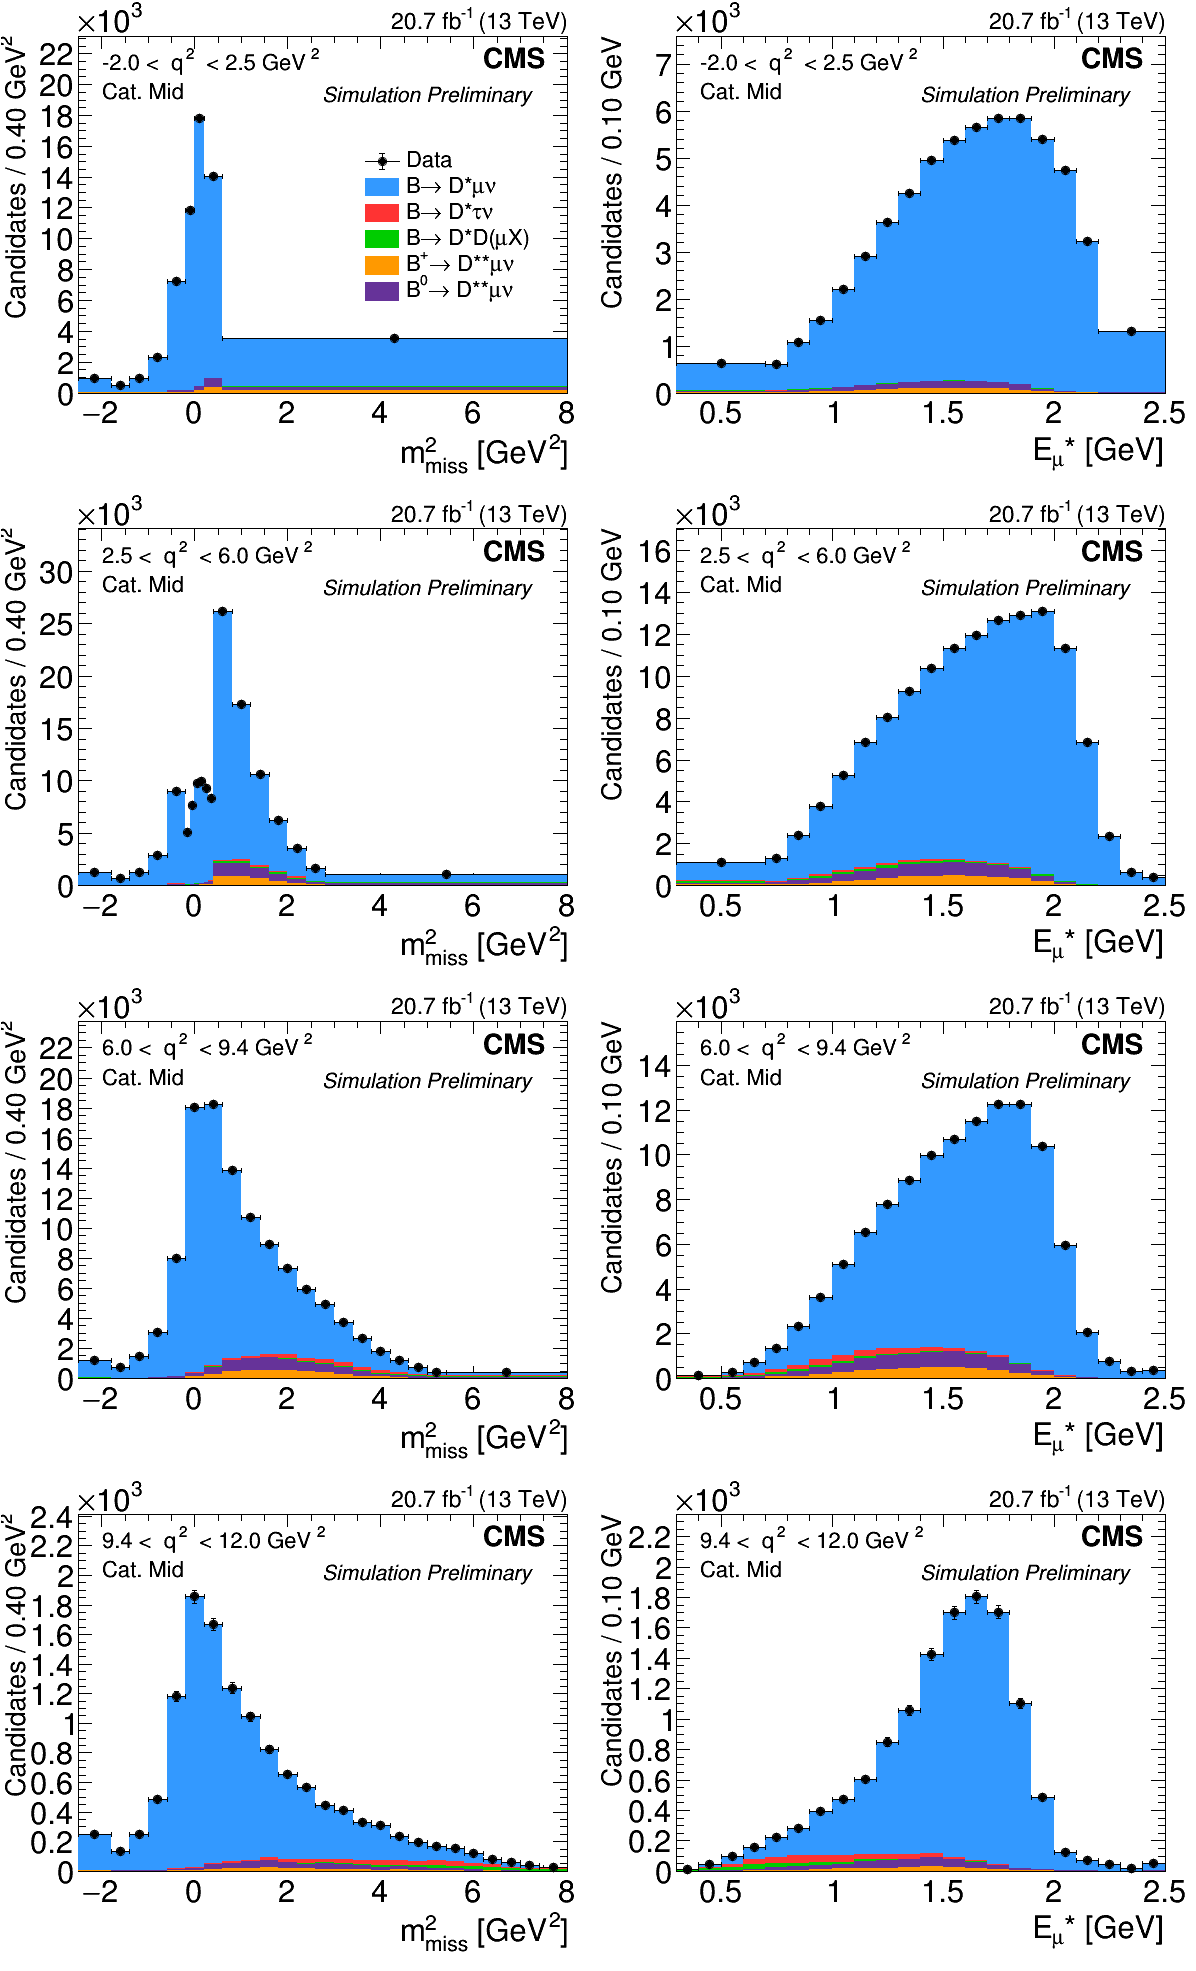

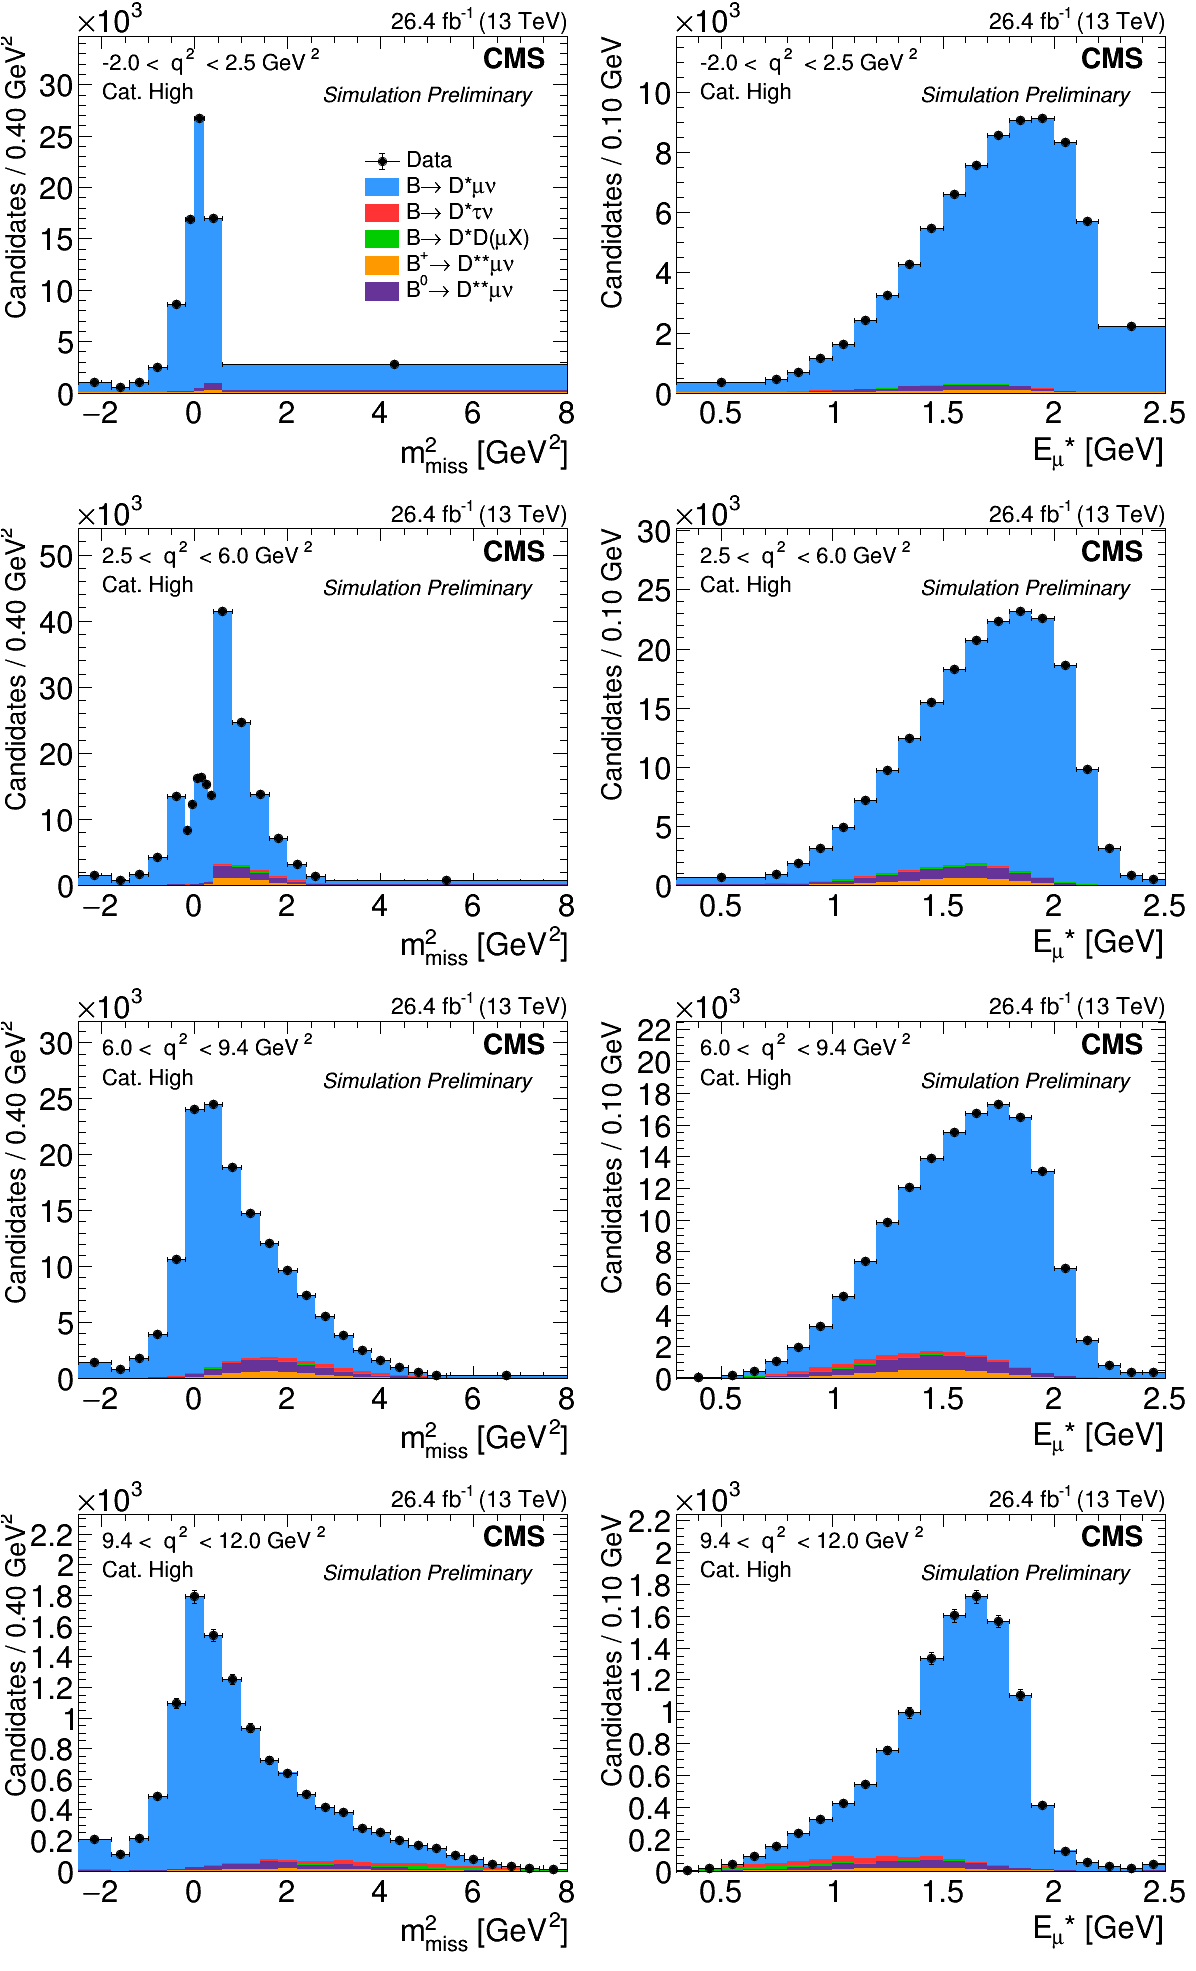

In [16]:
cSigPre = {}
for c in categoriesList:
    CMS_lumi.integrated_lumi = expectedLumi[c]
    cSigPre[c] = plot_gridVarQ2(CMS_lumi, binning, histo[c], 
                                scale_dic=scale_dic, min_y=0, logy=False, 
                                iq2_maskData=[2, 3] if blinded_fit else [],
                                categoryText=c.capitalize())
    cSigPre[c].SaveAs(outdir + '/fig/preFit_signalRegion_{}.png'.format(c))

In [17]:
if 'MVA' in histo['low']:
    cMVAPre = {}
    for c in categoriesList:
        CMS_lumi.integrated_lumi = expectedLumi[c]        
        histo[c]['MVA']['data'].GetXaxis().SetTitle('MVA score')
        cMVAPre[c] = plot_SingleCategory(CMS_lumi, histo[c]['MVA'], scale_dic=scale_dic,
                                      addText='Cat. '+c.capitalize(), logy=True, legBkg=True,
                                      procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                      min_y=1, tag=c+'MVA', legLoc=[0.25, 0.4, 0.5, 0.7])
        cMVAPre[c].SaveAs(outdir + '/fig/preFit_MVA_{}.png'.format(c))

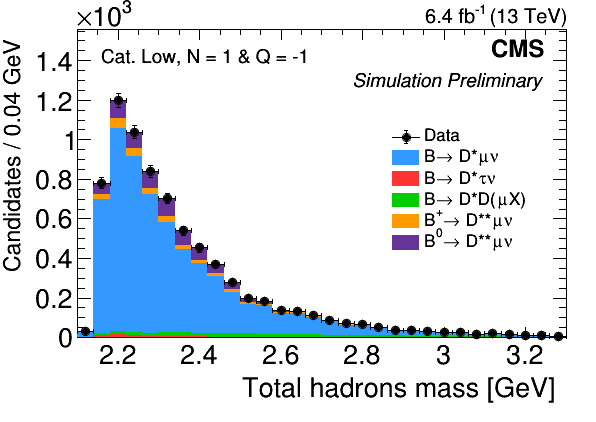

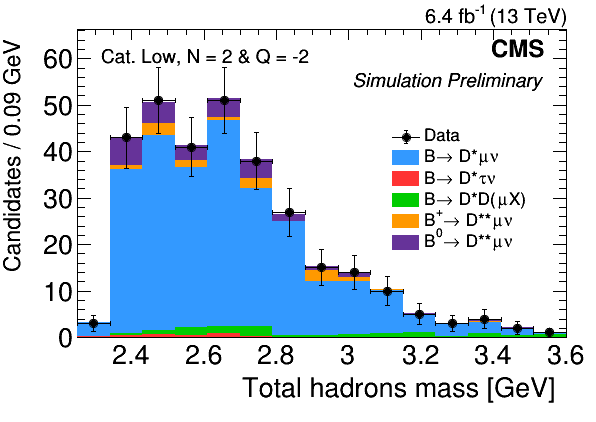

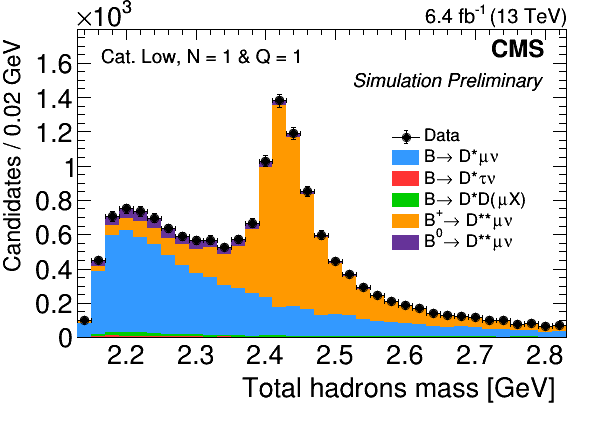

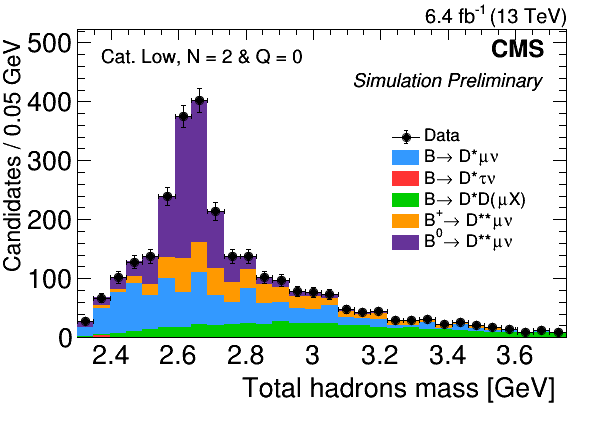

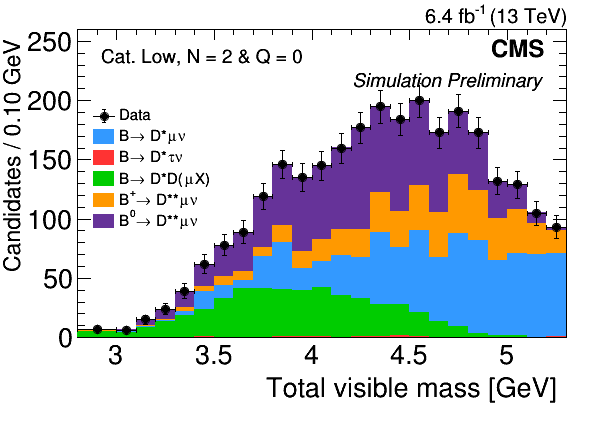

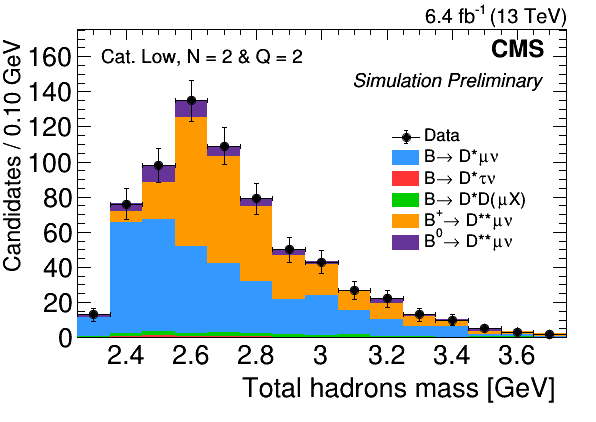

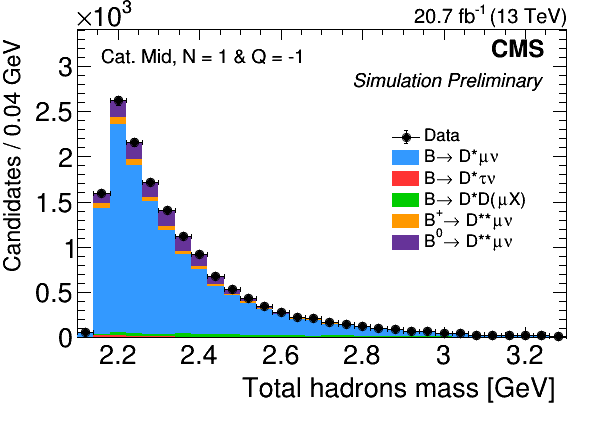

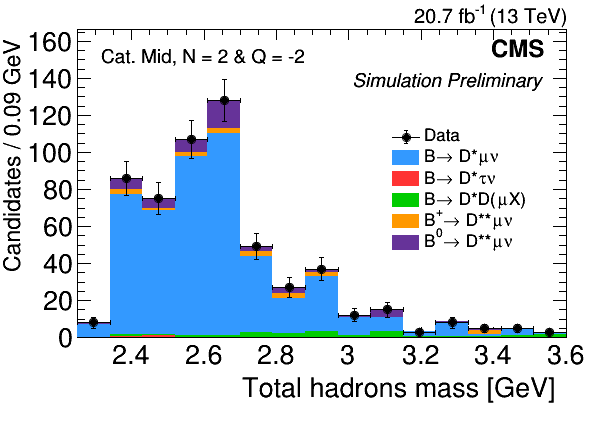

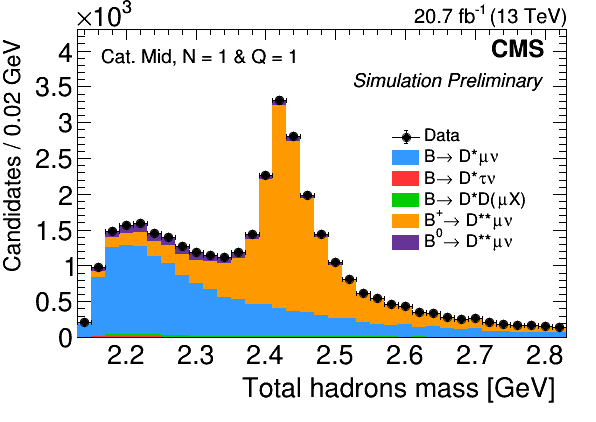

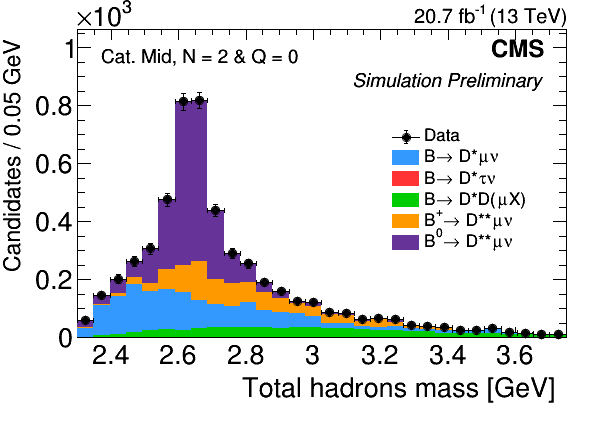

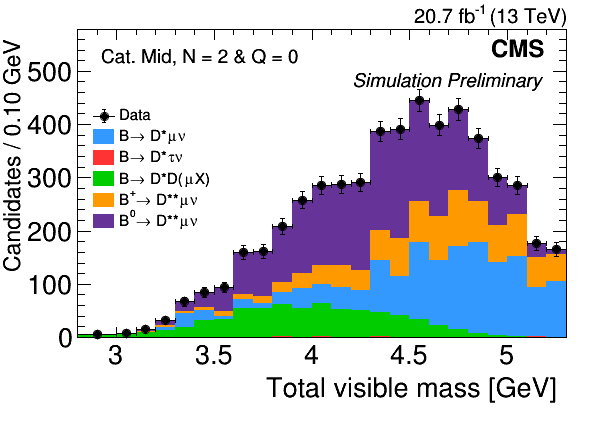

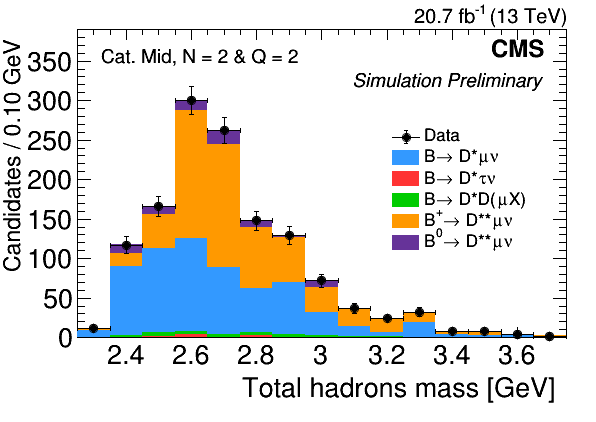

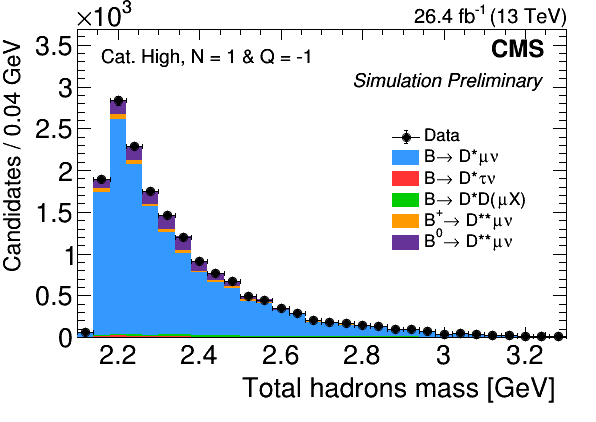

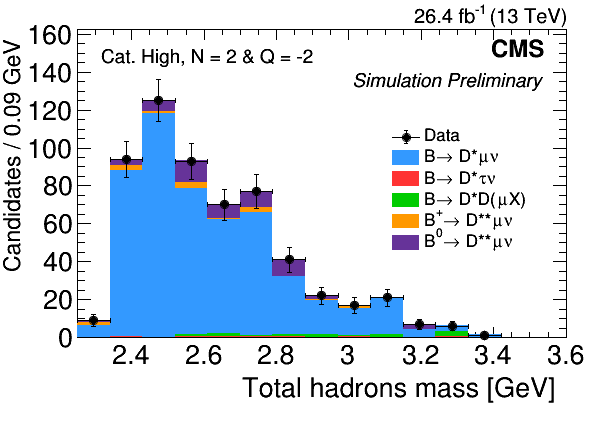

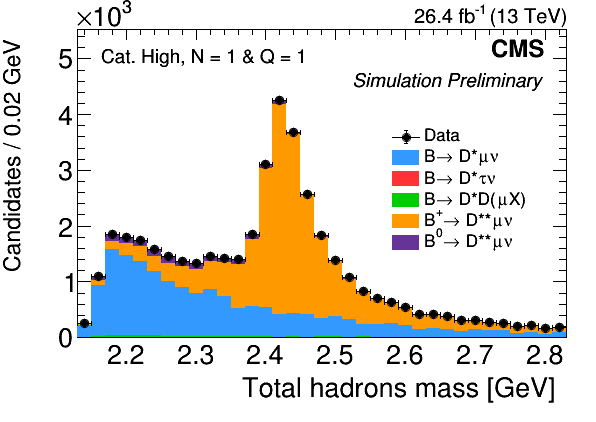

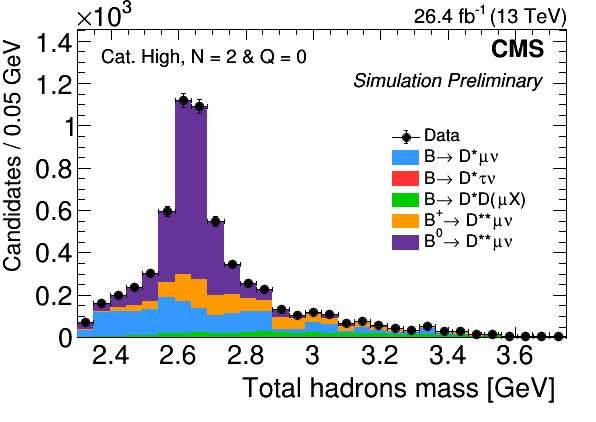

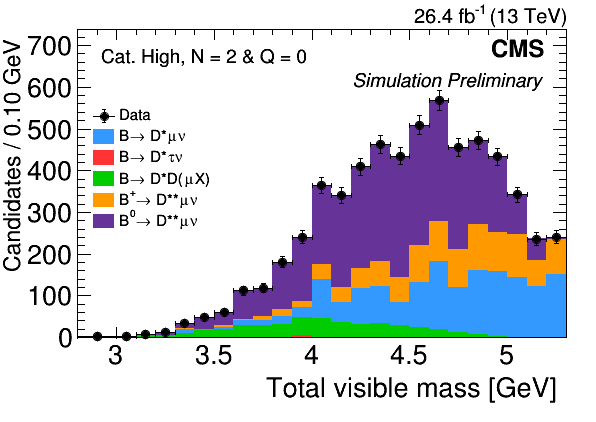

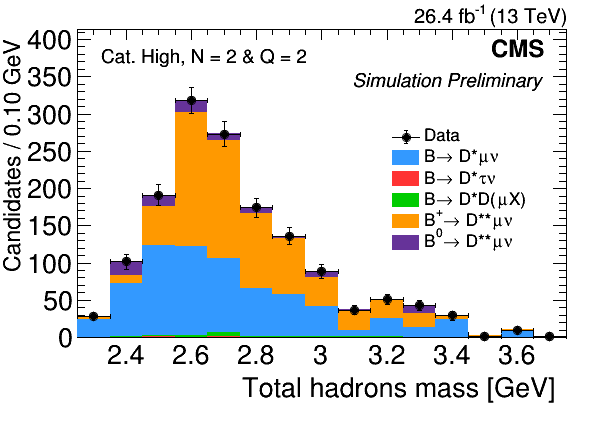

In [18]:
cSidePre = {}
for c in categoriesList:
    cSidePre[c] = {}
    CMS_lumi.integrated_lumi = expectedLumi[c]
    for k in np.sort([k for k in histo[c].keys() if k.startswith('Add')]):
        legLoc = [0.65, 0.4, 0.9, 0.7]
        if 'mVis' in k:
            legLoc = [0.15, 0.45, 0.35, 0.75]
        cSidePre[c][k] = plot_SingleCategory(CMS_lumi, histo[c][k], scale_dic=scale_dic,
                                             xtitle=getControlXtitle(k), 
                                             addText='Cat. '+c.capitalize() + ', ' + getControlSideText(k), 
                                             min_y=0, tag=c+k, legLoc=legLoc)
        cSidePre[c][k].SaveAs(outdir + '/fig/preFit_{}_{}.png'.format(k, c))        

# Run Combine

In [19]:
if not runCombine:
    raise

In [20]:
globalChannelMasking = [
#     'AddTk_p_mHad',
#     'AddTk_m_mHad',
#     'AddTk_pm_mVis',
    'AddTk_pm_mHad',
#     'AddTk_pp_mHad',
#     'AddTk_mm_mHad',
#     'Unrolled_q2bin0',
#     'Unrolled_q2bin1',
#     'Unrolled_q2bin2',
#     'Unrolled_q2bin3', 
    
    'Est_mu_q2bin0',
    'Est_mu_q2bin1',
    'Est_mu_q2bin2',
    'Est_mu_q2bin3',
    'M2_miss_q2bin0',
    'M2_miss_q2bin1',
    'M2_miss_q2bin2',
    'M2_miss_q2bin3',
#     'MVA'
]

if blinded_fit:
    globalChannelMasking += ['Unrolled_q2bin2', 'Unrolled_q2bin3']
#     globalChannelMasking += ['M2_miss_q2bin2', 'M2_miss_q2bin3']
    pass

aux = []
for c in categoriesList:
    for cm in globalChannelMasking:
        aux.append('mask_{}_{}=1'.format(c, cm))
globalChannelMaskingStr = ','.join(aux)
print globalChannelMaskingStr

mask_low_AddTk_pm_mHad=1,mask_low_Est_mu_q2bin0=1,mask_low_Est_mu_q2bin1=1,mask_low_Est_mu_q2bin2=1,mask_low_Est_mu_q2bin3=1,mask_low_M2_miss_q2bin0=1,mask_low_M2_miss_q2bin1=1,mask_low_M2_miss_q2bin2=1,mask_low_M2_miss_q2bin3=1,mask_mid_AddTk_pm_mHad=1,mask_mid_Est_mu_q2bin0=1,mask_mid_Est_mu_q2bin1=1,mask_mid_Est_mu_q2bin2=1,mask_mid_Est_mu_q2bin3=1,mask_mid_M2_miss_q2bin0=1,mask_mid_M2_miss_q2bin1=1,mask_mid_M2_miss_q2bin2=1,mask_mid_M2_miss_q2bin3=1,mask_high_AddTk_pm_mHad=1,mask_high_Est_mu_q2bin0=1,mask_high_Est_mu_q2bin1=1,mask_high_Est_mu_q2bin2=1,mask_high_Est_mu_q2bin3=1,mask_high_M2_miss_q2bin0=1,mask_high_M2_miss_q2bin1=1,mask_high_M2_miss_q2bin2=1,mask_high_M2_miss_q2bin3=1


## Run Bias

In [ ]:
if runBias:
    nToys = 50
    cmd = 'combine -M GenerateOnly'
    cmd += ' -d ' + card_location.replace('.txt', '.root')
    cmd += ' --seed 6741'
    cmd += ' --noMCbonly 1'
    cmd += ' --setParameters r={},{} --freezeParameters r'.format(SM_RDst, globalChannelMaskingStr)
    cmd += ' --toysFrequentist -t {} --saveToys'.format(nToys)
    cmd += ' -n {} -m {:.0f}'.format(card_name, 100*SM_RDst)
    print cmd
    status, output = commands.getstatusoutput(cmd)
    if status:
        print output
        raise

#     cmd = 'combine -M FitDiagnostics'
    cmd = 'combine -M MultiDimFit --algo grid --points=100'
    cmd += ' --robustFit 1 --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic'
#     cmd += ' --skipBOnlyFit'
    cmd += ' --seed 6742'
    cmd += ' -d ' + card_location.replace('.txt', '.root')
    cmd += ' --toysFile higgsCombine{}.GenerateOnly.mH{}.6741.root -t {}'.format(card_name, 100*SM_RDst, nToys)
    cmd += ' --setParameters r={:.2f},{}'.format(SM_RDst, globalChannelMaskingStr)
    cmd += ' --setParameterRanges r=0.1,0.6'
    cmd += ' -n {}_toys -m {:.0f}'.format(card_name, 100*SM_RDst)
#     cmd += ' --out ' + outdir
#     cmd += ' --trackParameters rgx{.*}'
    cmd += ' --verbose 1'
    print cmd
    
    status, output = commands.getstatusoutput(cmd)
    for line in output.split('\n'):
        if 'ERROR' in line: print line.replace('ERROR', '\033[1m\x1b[31mError\x1b[0m')
    if status:
        print output
        raise
        
    if os.path.isdir(outdir + '/biasStudyToys'):
        os.system('rm -rf ' + outdir + '/biasStudyToys')
    os.system('mkdir ' + outdir + '/biasStudyToys')
    os.system('mv -v *{}*.GenerateOnly.*.root '.format(card_name) + outdir + '/biasStudyToys/')
#     os.system('mv -v higgsCombine{}_toys.FitDiagnostics.*.root '.format(card_name) + outdir + '/biasStudyToys/')
    os.system('mv -v higgsCombine{}_toys.MultiDimFit.*.root '.format(card_name) + outdir + '/biasStudyToys/')
    os.system('mv combine_logger.out ' + outdir + '/')

In [ ]:
if runBias:
#     f = ur.open(outdir+'/fitDiagnostics{}_toys.root'.format(card_name))
#     r = f['tree_fit_sb']['r'].array()
#     rLoErr = f['tree_fit_sb']['rLoErr'].array()
#     rHiErr = f['tree_fit_sb']['rHiErr'].array()
    fname = 'higgsCombine{}_toys.MultiDimFit.mH{:.0f}.6742.root'.format(card_name, 100*SM_RDst)
    res = getUncertaintyFromLimitTree(outdir + '/biasStudyToys/'+fname, verbose=False)
    r = res[:,0]
    rLoErr = res[:,1]
    rHiErr = res[:,2]
    
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(8,6))
    plt.errorbar(np.arange(1, 1+r.shape[0]), r, yerr=np.column_stack((rLoErr, rHiErr)).T, fmt='o', color='#1f77b4', label='Toys fit results')
    m = np.mean(r)
    sm = np.std(r)/np.sqrt(r.shape[0])
    x = [0, r.shape[0]+1]
    plt.fill_between(x, 2*[m-sm], 2*[m+sm], color='#ff7f0e', alpha=0.3)
    plt.plot(x, 2*[m], color='#d62728', lw=1, label='Toys mean')
    plt.plot(x, [SM_RDst, SM_RDst], 'm--', lw=2, label='Injected value')
    plt.legend(loc='upper right', numpoints=1)
    plt.xlabel('Toy number')
    plt.ylabel(r'$R(D^*)$')
    plt.savefig(outdir + '/fig/biasStudy_toysResults.png')
    
    z = (r - SM_RDst)/(0.5*(rLoErr + rHiErr))
    h = create_TH1D(z, name='hZtest', binning=[int(2*np.sqrt(r.shape[0])), -4, 4], axis_title=['#hat{R(D*)} - R(D*) / #sigma', 'Number of toys'])
    h.Sumw2()
    h.Fit('gaus', 'ILQ')
    rt.gStyle.SetStatY(0.95)
    c = drawOnCMSCanvas(CMS_lumi, [h])
    c.Draw()
    c.SaveAs(outdir + '/fig/biasStudy_zTest.png')

## Pre scan

combine -M MultiDimFit --algo grid --points=50 --robustFit 1 -d cards/v2combination_Asimov.root --X-rtd MINIMIZER_analytic --rMin=0.1000 --rMax=0.7000 -n v2combination_Asimov_preFitScan --setParameters r=0.29,mask_low_AddTk_pm_mHad=1,mask_low_Est_mu_q2bin0=1,mask_low_Est_mu_q2bin1=1,mask_low_Est_mu_q2bin2=1,mask_low_Est_mu_q2bin3=1,mask_low_M2_miss_q2bin0=1,mask_low_M2_miss_q2bin1=1,mask_low_M2_miss_q2bin2=1,mask_low_M2_miss_q2bin3=1,mask_mid_AddTk_pm_mHad=1,mask_mid_Est_mu_q2bin0=1,mask_mid_Est_mu_q2bin1=1,mask_mid_Est_mu_q2bin2=1,mask_mid_Est_mu_q2bin3=1,mask_mid_M2_miss_q2bin0=1,mask_mid_M2_miss_q2bin1=1,mask_mid_M2_miss_q2bin2=1,mask_mid_M2_miss_q2bin3=1,mask_high_AddTk_pm_mHad=1,mask_high_Est_mu_q2bin0=1,mask_high_Est_mu_q2bin1=1,mask_high_Est_mu_q2bin2=1,mask_high_Est_mu_q2bin3=1,mask_high_M2_miss_q2bin0=1,mask_high_M2_miss_q2bin1=1,mask_high_M2_miss_q2bin2=1,mask_high_M2_miss_q2bin3=1 --verbose -1
----------------------------------
R(D*) = 0.295 +0.029/-0.029 [9.9 %]
Sigma = 0.0

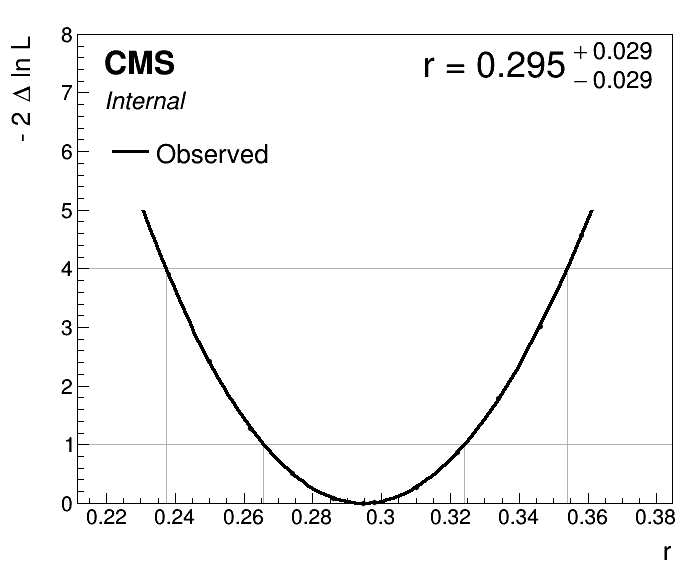

 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
Set Default Value of Parameter r To : 0.29
Set Default Value of Parameter mask_low_AddTk_pm_mHad To : 1
Set Default Value of Parameter mask_low_Est_mu_q2bin0 To : 1
Set Default Value of Parameter mask_low_Est_mu_q2bin1 To : 1
Set Default Value of Parameter mask_low_Est_mu_q2bin2 To : 1
Set Default Value of Parameter mask_low_Est_mu_q2bin3 To : 1
Set Default Value of Parameter mask_low_M2_miss_q2bin0 To : 1
Set Default Value of Parameter mask_low_M2_miss_q2bin1 To : 1
Set Default Value of Parameter mask_low_M2_miss_q2bin2 To : 1
Set Default Value of Parameter mask_low_M2_miss_q2bin3 To : 1
Set Default Value of Parameter mask_mid_AddTk_pm_mHad To : 1
Set Default Value of Parameter mask_mid_Est_mu_q2bin0 To : 1
Set Default Value of Parameter mask_mid_Est_mu_q2bin1 To : 1
Set Default Val

Info in <TCanvas::Print>: pdf file ./scan.pdf has been created
Info in <TCanvas::Print>: png file ./scan.png has been created


In [21]:
if use_real_data:
    rDst_postFitRegion = [0.1, 1.]
else:
    rDst_postFitRegion = [0.1, 0.7]

cmd = 'combine'
cmd += ' -M MultiDimFit'
cmd += ' --algo grid --points=50'
cmd += ' --robustFit 1'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_preFitScan'.format(card_name)
cmd += ' --setParameters r={:.2f},{}'.format(SM_RDst, globalChannelMaskingStr)
cmd += ' --verbose -1'
print cmd
os.system(cmd)
cmd = 'plot1DScan.py higgsCombine{}_preFitScan.MultiDimFit.mH120.root'.format(card_name)
cmd += '; mv scan.png {}/scan_preFit.png; rm scan.root'.format(outdir)
cmd += '; mv higgsCombine{}_preFitScan.MultiDimFit.mH120.root {}/'.format(card_name, outdir)
os.system(cmd)
res = getUncertaintyFromLimitTree(outdir+'/higgsCombine{}_preFitScan.MultiDimFit.mH120.root'.format(card_name))
rDst_postFitRegion = [res[0] - 3*res[1], res[0] + 3*res[2]]
fit_RDst = res[0]
display(Image(filename=outdir+'/scan_preFit.png'))

## Run the fit Diagnostic

In [22]:
seedMLf = '6741'
forceRDst = False

In [26]:
cmd = 'combine -M FitDiagnostics'
cmd += ' --robustFit 1 --robustHesse 1 --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic'
cmd += ' --seed ' + seedMLf
cmd += ' -d ' + card_location.replace('.txt', '.root')
if forceRDst:
    cmd += ' --setParameterRanges r={:.2f},{:.2f}'.format(0, 1)  
    cmd += ' --customStartingPoint --setParameters r={:.3f}'.format(SM_RDst)
else:
    cmd += ' --skipBOnlyFit'
    cmd += ' --setParameterRanges r={:.2f},{:.2f}'.format(0,1)  
    cmd += ' --setParameters r={:.3f}'.format(fit_RDst)
if globalChannelMaskingStr:
    cmd += ',' + globalChannelMaskingStr
runName = card_name + ('_RDstFixed' if forceRDst else '')
cmd += ' -n ' + runName
cmd += ' --out ' + outdir
cmd += ' --saveShapes --saveWithUncertainties --saveNormalizations --saveWorkspace'
cmd += ' --trackParameters rgx{.*}'
cmd += ' --plots'
cmd += ' --verbose 1'

if runFitDiagnostics:
    print cmd
    status, output = commands.getstatusoutput(cmd)

    if status:
        print output
        raise
    for line in output.split('\n'):
            if 'ERROR' in line: print line.replace('ERROR', '\033[1m\x1b[31mError\x1b[0m')
            if line.startswith('customStartingPoint'): print line
    os.system('mv combine_logger.out ' + outdir + '/combine_logger_FitDiagnostics.out')
    os.system('mv ./higgsCombine{}.FitDiagnostics.mH120.{}.root '.format(runName, seedMLf) + outdir + '/');
    
    f = ur.open(glob(outdir + '/higgsCombine{}.FitDiagnostics.mH120.{}.root'.format(runName, seedMLf))[0])
    c, d, u, _ = f['limit']['limit'].array()
    print 'R(D*) = {:.3f} +{:.3f}/-{:.3f} [{:.1f} %]'.format(c, u-c, c-d, 100*(u-d)*0.5/c)

combine -M FitDiagnostics --robustFit 1 --robustHesse 1 --cminDefaultMinimizerStrategy 0 --X-rtd MINIMIZER_analytic --seed 6741 -d cards/v2combination_Asimov.root --skipBOnlyFit --setParameterRanges r=0.00,1.00 --setParameters r=0.295,mask_low_AddTk_pm_mHad=1,mask_low_Est_mu_q2bin0=1,mask_low_Est_mu_q2bin1=1,mask_low_Est_mu_q2bin2=1,mask_low_Est_mu_q2bin3=1,mask_low_M2_miss_q2bin0=1,mask_low_M2_miss_q2bin1=1,mask_low_M2_miss_q2bin2=1,mask_low_M2_miss_q2bin3=1,mask_mid_AddTk_pm_mHad=1,mask_mid_Est_mu_q2bin0=1,mask_mid_Est_mu_q2bin1=1,mask_mid_Est_mu_q2bin2=1,mask_mid_Est_mu_q2bin3=1,mask_mid_M2_miss_q2bin0=1,mask_mid_M2_miss_q2bin1=1,mask_mid_M2_miss_q2bin2=1,mask_mid_M2_miss_q2bin3=1,mask_high_AddTk_pm_mHad=1,mask_high_Est_mu_q2bin0=1,mask_high_Est_mu_q2bin1=1,mask_high_Est_mu_q2bin2=1,mask_high_Est_mu_q2bin3=1,mask_high_M2_miss_q2bin0=1,mask_high_M2_miss_q2bin1=1,mask_high_M2_miss_q2bin2=1,mask_high_M2_miss_q2bin3=1 -n v2combination_Asimov --out results/v2combination_Asimov --saveShap

In [30]:
# Get post-fit shapes
n = outdir + '/fitDiagnostics{}.root'.format(card_name+ ('_RDstFixed' if forceRDst else ''))
fFitDiagnostics = rt.TFile.Open(n, 'READ')
if forceRDst:
    fd = fFitDiagnostics.shapes_fit_b
else:
    fd = fFitDiagnostics.shapes_fit_s

histo_postfit = {}
for c in categoriesList:
    histo_postfit[c] = {}
    for cat, h_dic in histo[c].iteritems():
        histo_postfit[c][cat] = {}
        for n, h in h_dic.iteritems():
            if '__' in n:
                continue
            h_post = h.Clone(h.GetName() + '_postfit')
            if 'data' in n:
                h_fit = fd.Get(c+'_'+cat+'/total')
                h_data = h.Clone(h.GetName() + '_data')
                for i in range(1, h_post.GetNbinsX()+1):
                    h_post.SetBinContent(i, h_fit.GetBinContent(i))
                    h_post.SetBinError(i, h_fit.GetBinError(i))     

                histo_postfit[c][cat]['total'] = h_post
                histo_postfit[c][cat][n] = h_data
            else:
                h_fit = fd.Get(c+'_'+cat+'/'+n)
                if not h_fit: 
                    print n+' missing from '+c+' '+cat
                    continue
                for i in range(1, h_post.GetNbinsX()+1):
                    h_post.SetBinContent(i, h_fit.GetBinContent(i))
                    h_post.SetBinError(i, h_fit.GetBinError(i)) 

                histo_postfit[c][cat][n] = h_post

BmDstmHc missing from low AddTk_pp_mHad
DstmDp missing from mid Unrolled_q2bin0
BmDstmHc missing from mid AddTk_pp_mHad
DstmDp missing from high Unrolled_q2bin0
DstmD0 missing from high Unrolled_q2bin0
BpDstmHc missing from high AddTk_mm_mHad


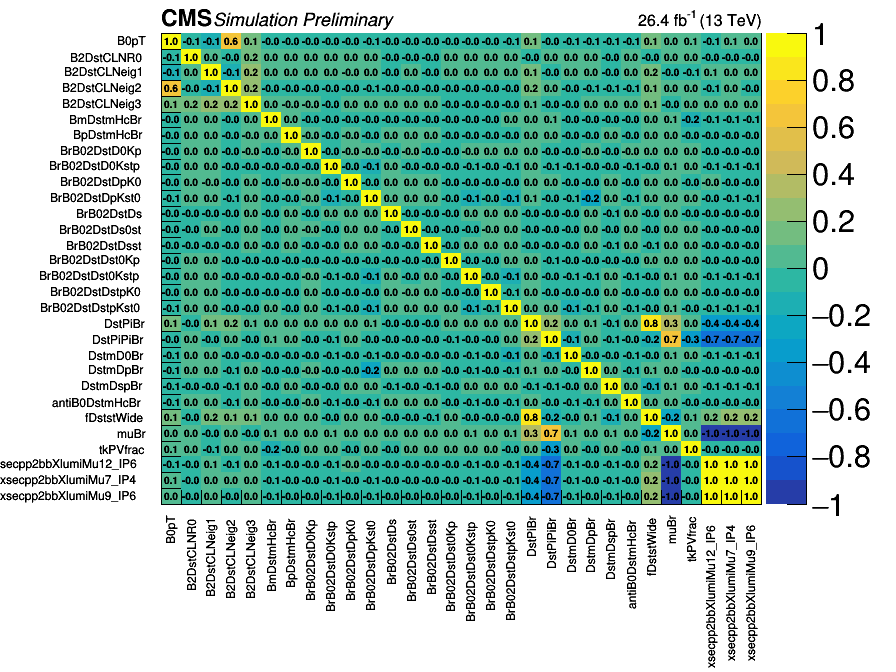

In [39]:
h2 = fFitDiagnostics.Get('covariance_fit_' + ('b' if forceRDst else 's'))
rt.gStyle.SetPaintTextFormat('.1f')

N = h2.GetNbinsX()
n=30

h2.GetXaxis().SetRange(1, n)
h2.GetYaxis().SetRangeUser(N-n, N)
h2.SetMarkerSize(.8)
h2.LabelsOption("v")
h2.GetXaxis().SetLabelSize(0.03)
h2.GetYaxis().SetLabelSize(0.03)
CC = drawOnCMSCanvas(CMS_lumi, [h2, h2], ['colz', 'text same'], size=(900, 700), 
                     tag='tl', mL=0.18, mR=0.15, mB=0.25)
CC.SaveAs(outdir+'/fig/covariance_zoom'+ ('_RDstFixed' if forceRDst else '')+'.png')

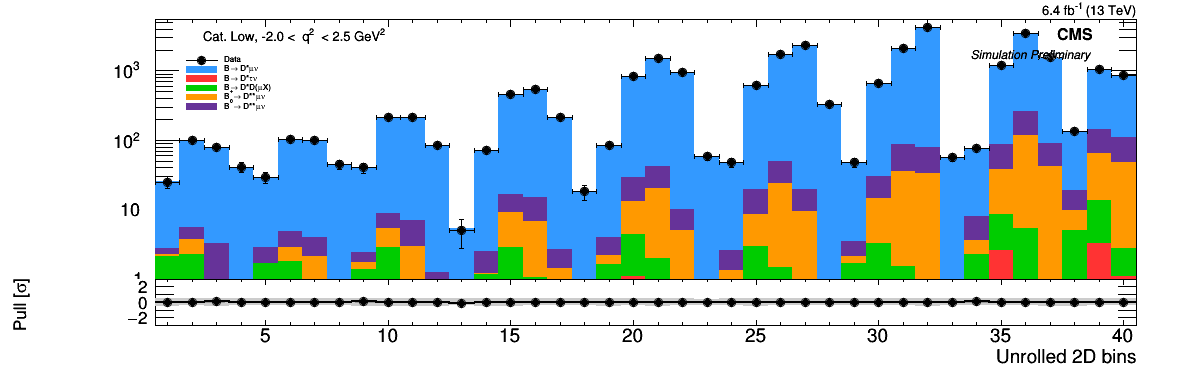

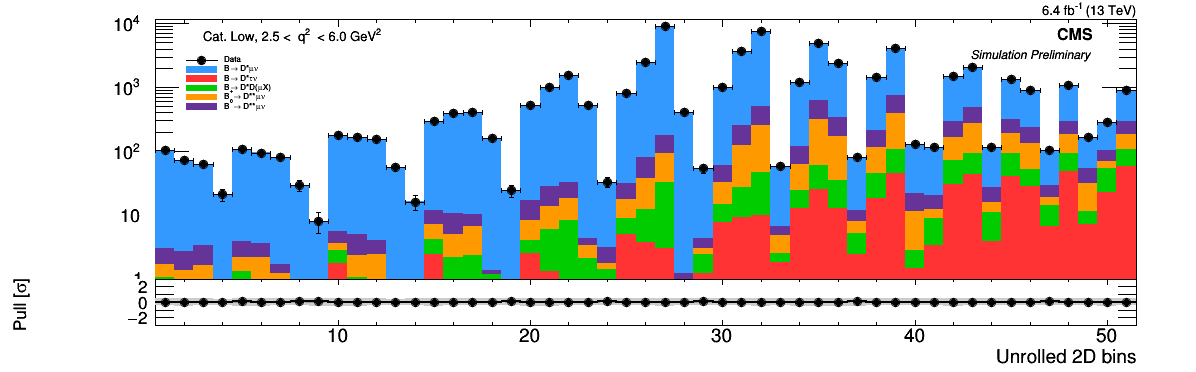

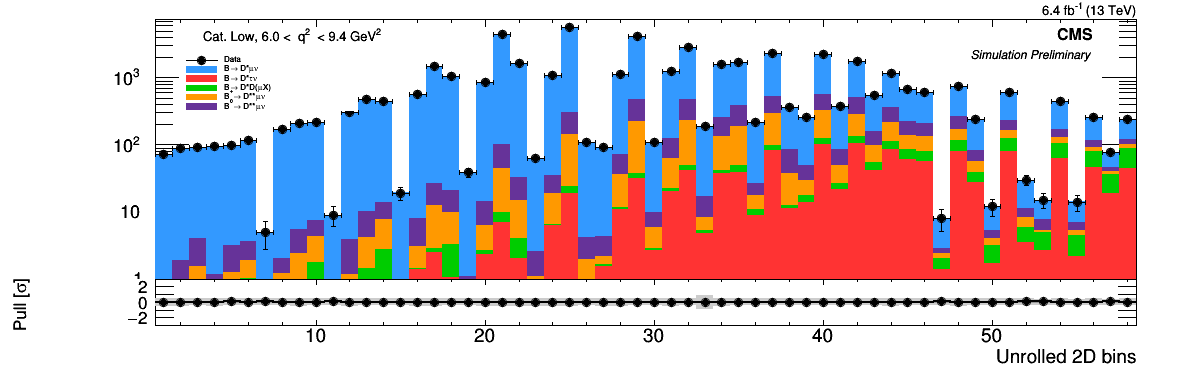

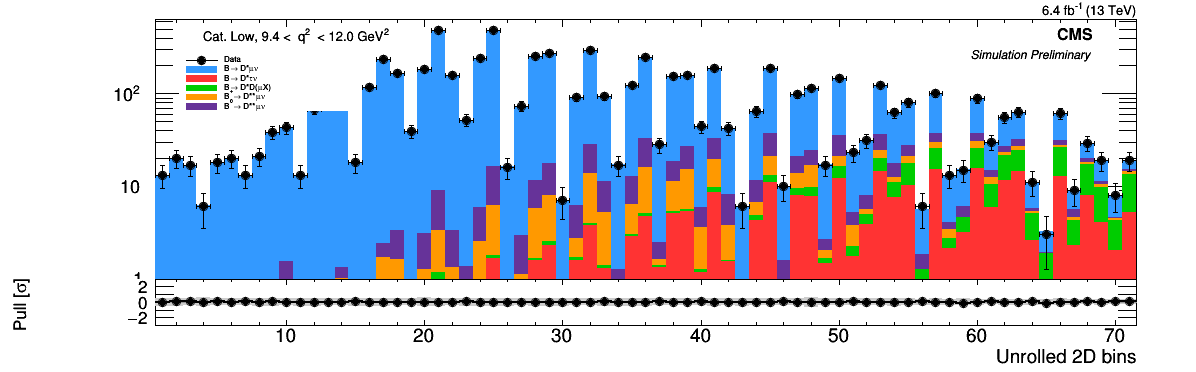

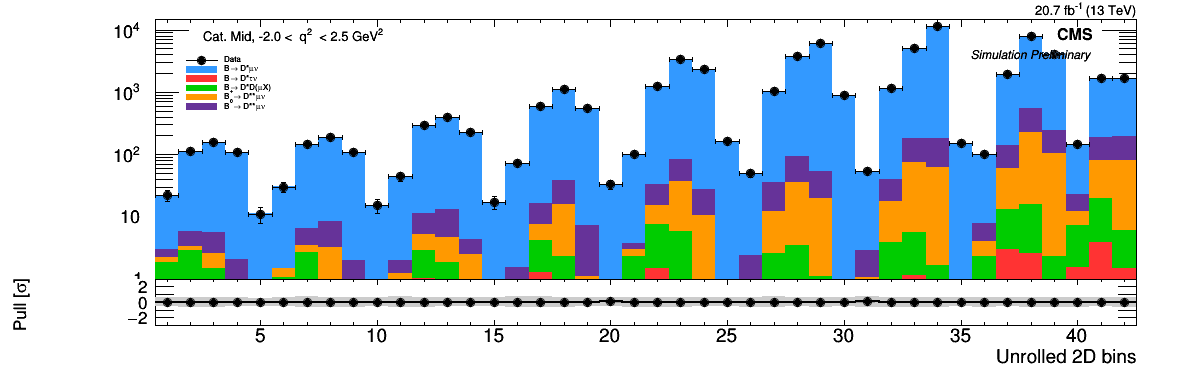

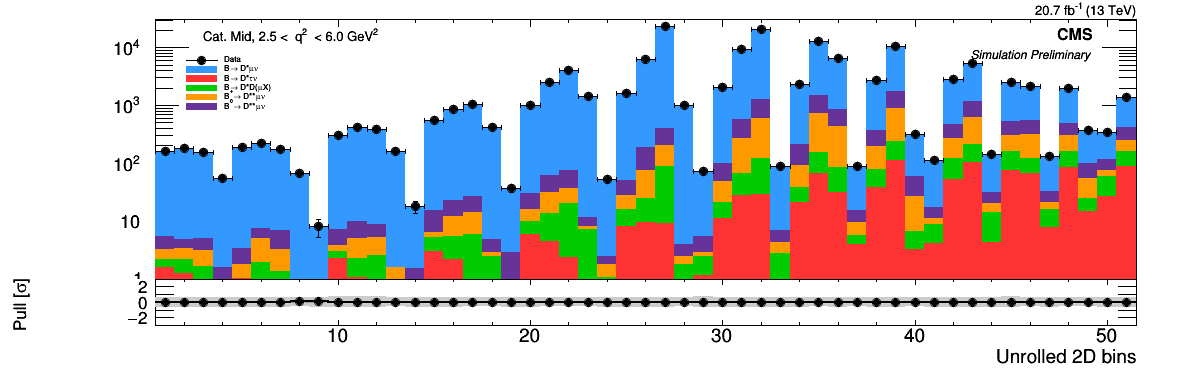

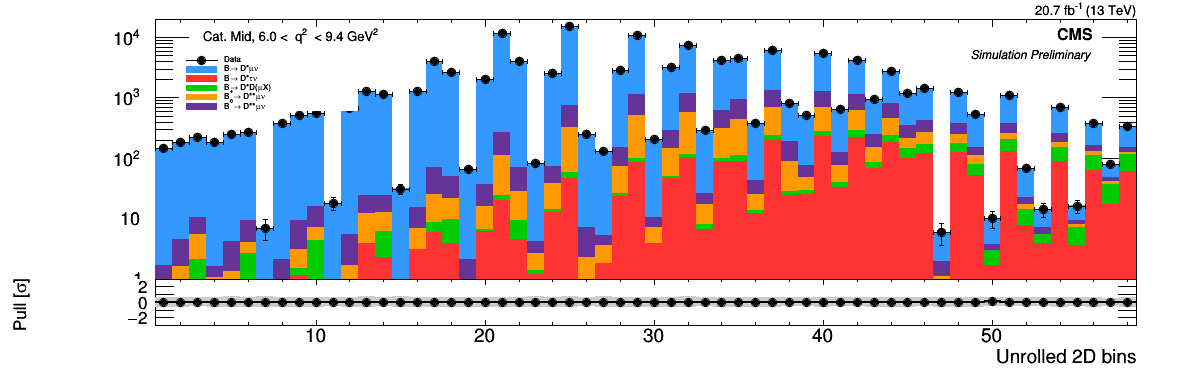

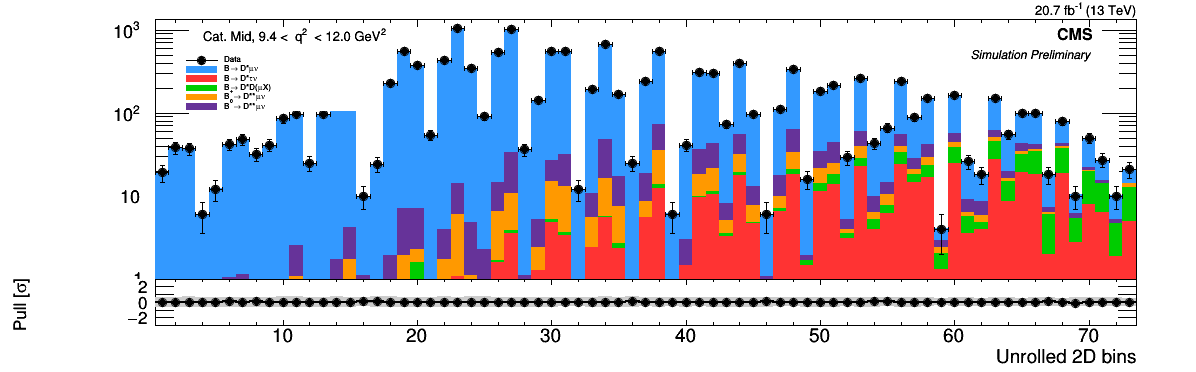

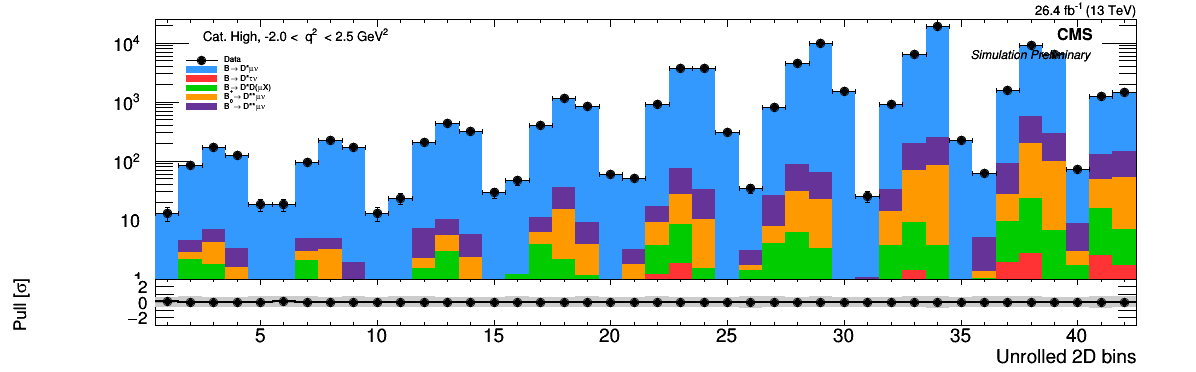

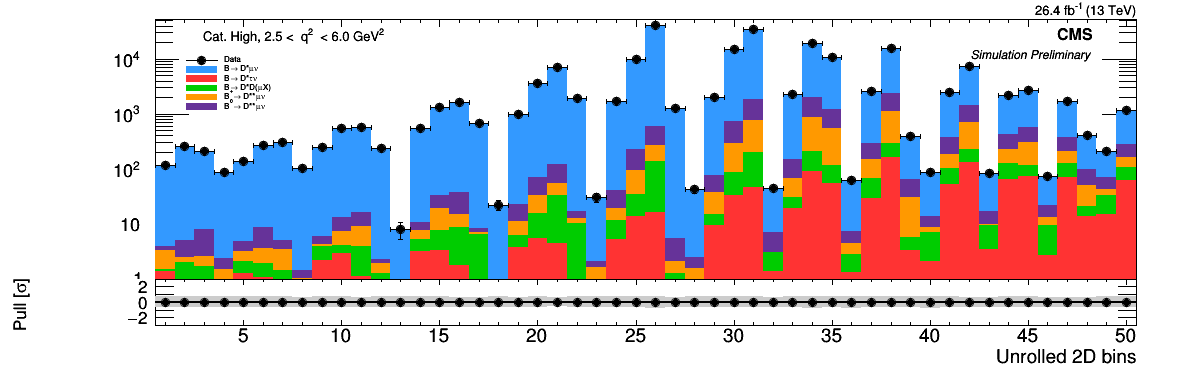

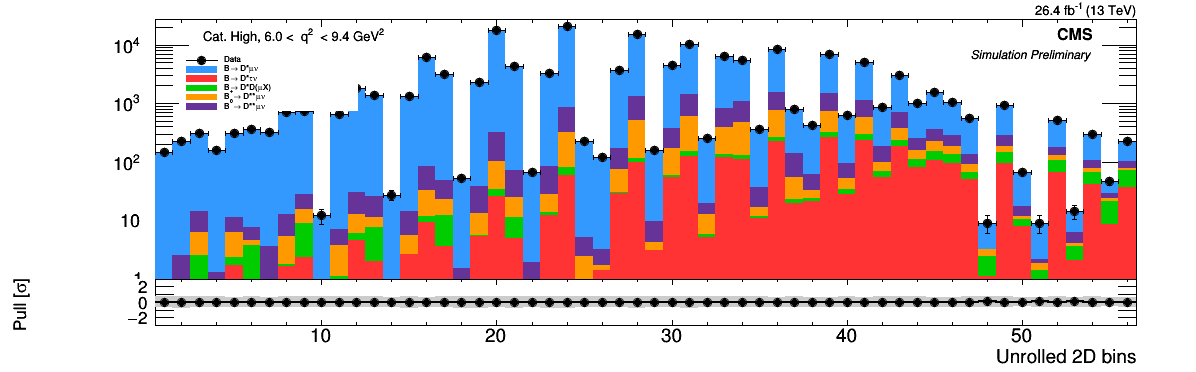

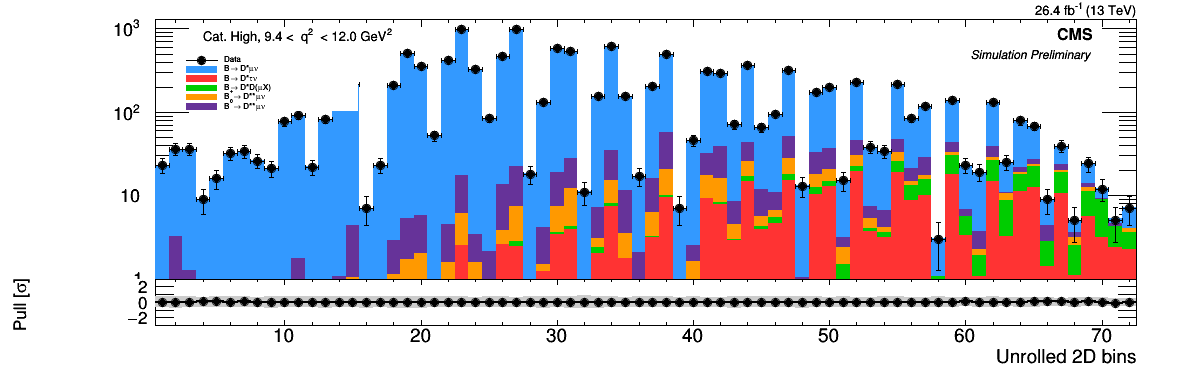

In [40]:
cUnrolledPost = {}
for c in categoriesList:
    CMS_lumi.integrated_lumi = expectedLumi[c]
    cUnrolledPost[c] = []
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        nameU = 'Unrolled_q2bin'+str(i_q2)
        histo_postfit[c][nameU]['data'].GetXaxis().SetTitle('Unrolled 2D bins')
        histo_postfit[c][nameU]['data'].GetYaxis().SetTitle('Events')
        cUnrolledPost[c].append(plot_SingleCategory(CMS_lumi, histo_postfit[c][nameU], draw_pulls=True,
                                                 addText='Cat. '+c.capitalize() + ', ' + '{:.1f} <  q^{{2}}  < {:.1f} GeV^{{2}}'.format(q2_l, q2_h), 
                                                 logy=True, legBkg=True,
                                                 procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                                 min_y=1, 
                                                 tag='Unrolled_q2bin'+str(i_q2)+c, 
                                                 legLoc=[0.15, 0.6, 0.3, 0.8],
                                                 maskData = blinded_fit and (False if i_q2 < 2 else True),
                                                 figsize = [1200, 400]
                                          ))
        n = outdir+'/fig/Unrolled_q2bin'+str(i_q2)+'_'+c+'_postfit'+ ('_RDstFixed' if forceRDst else '')+'.png'
        cUnrolledPost[c][i_q2].SaveAs(n)

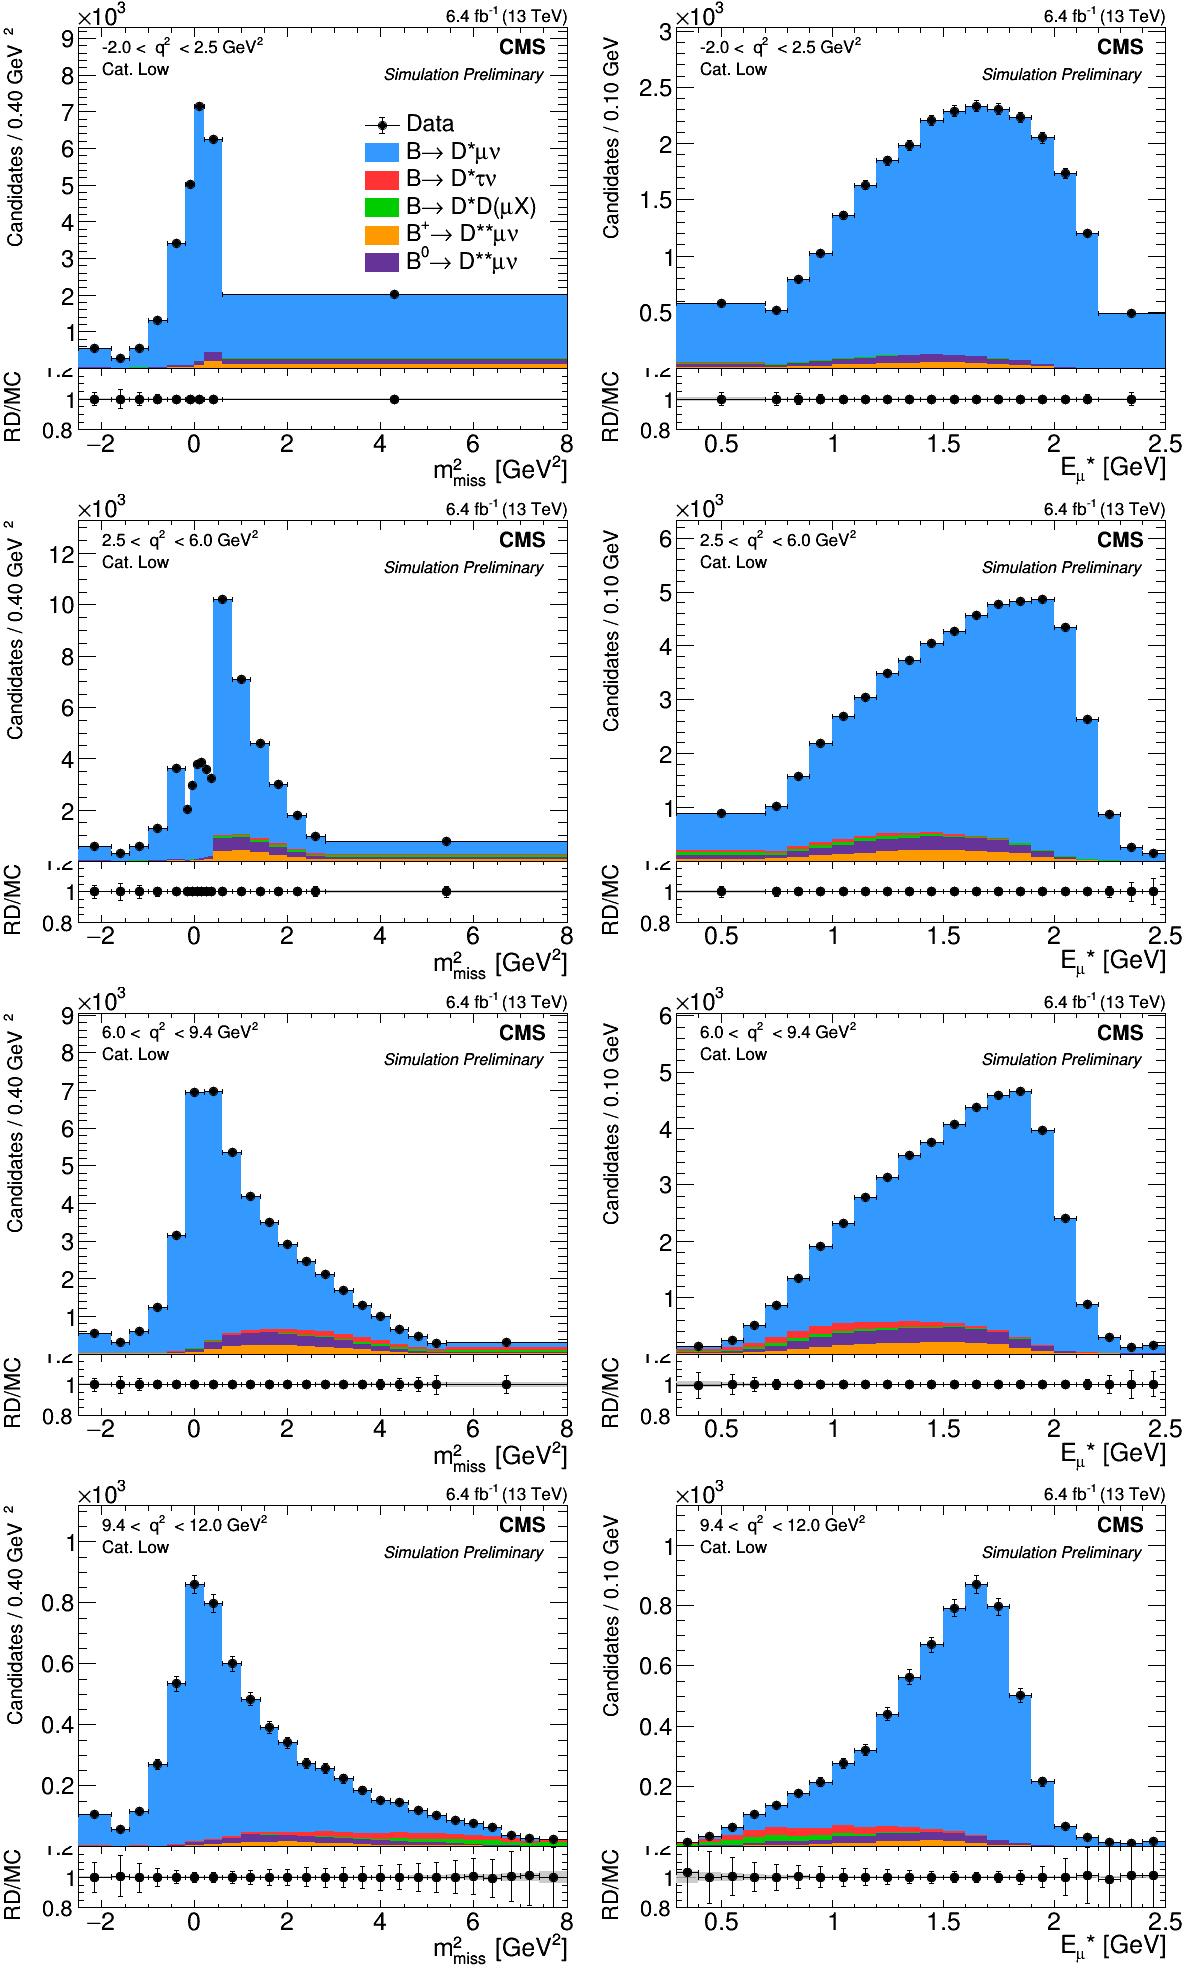

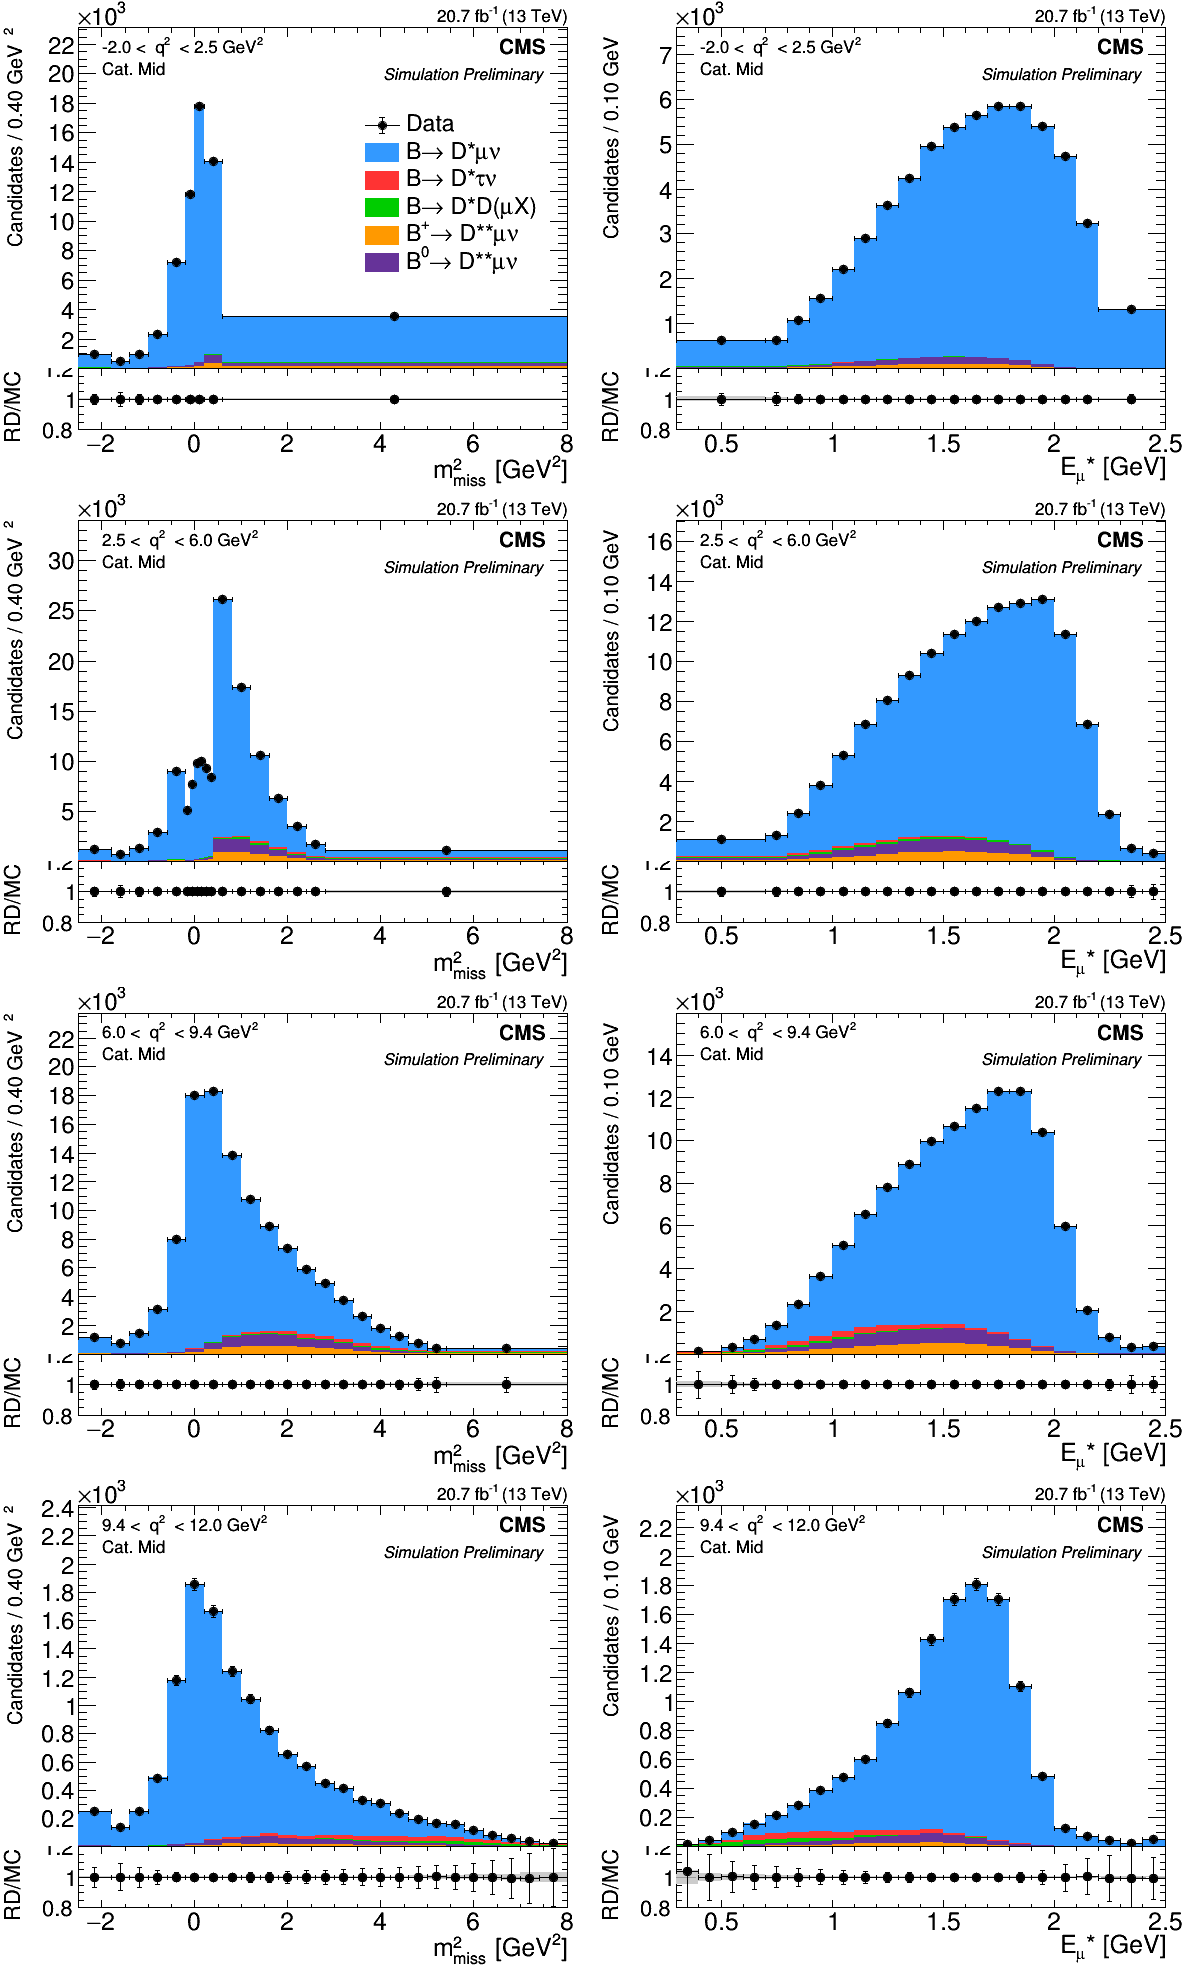

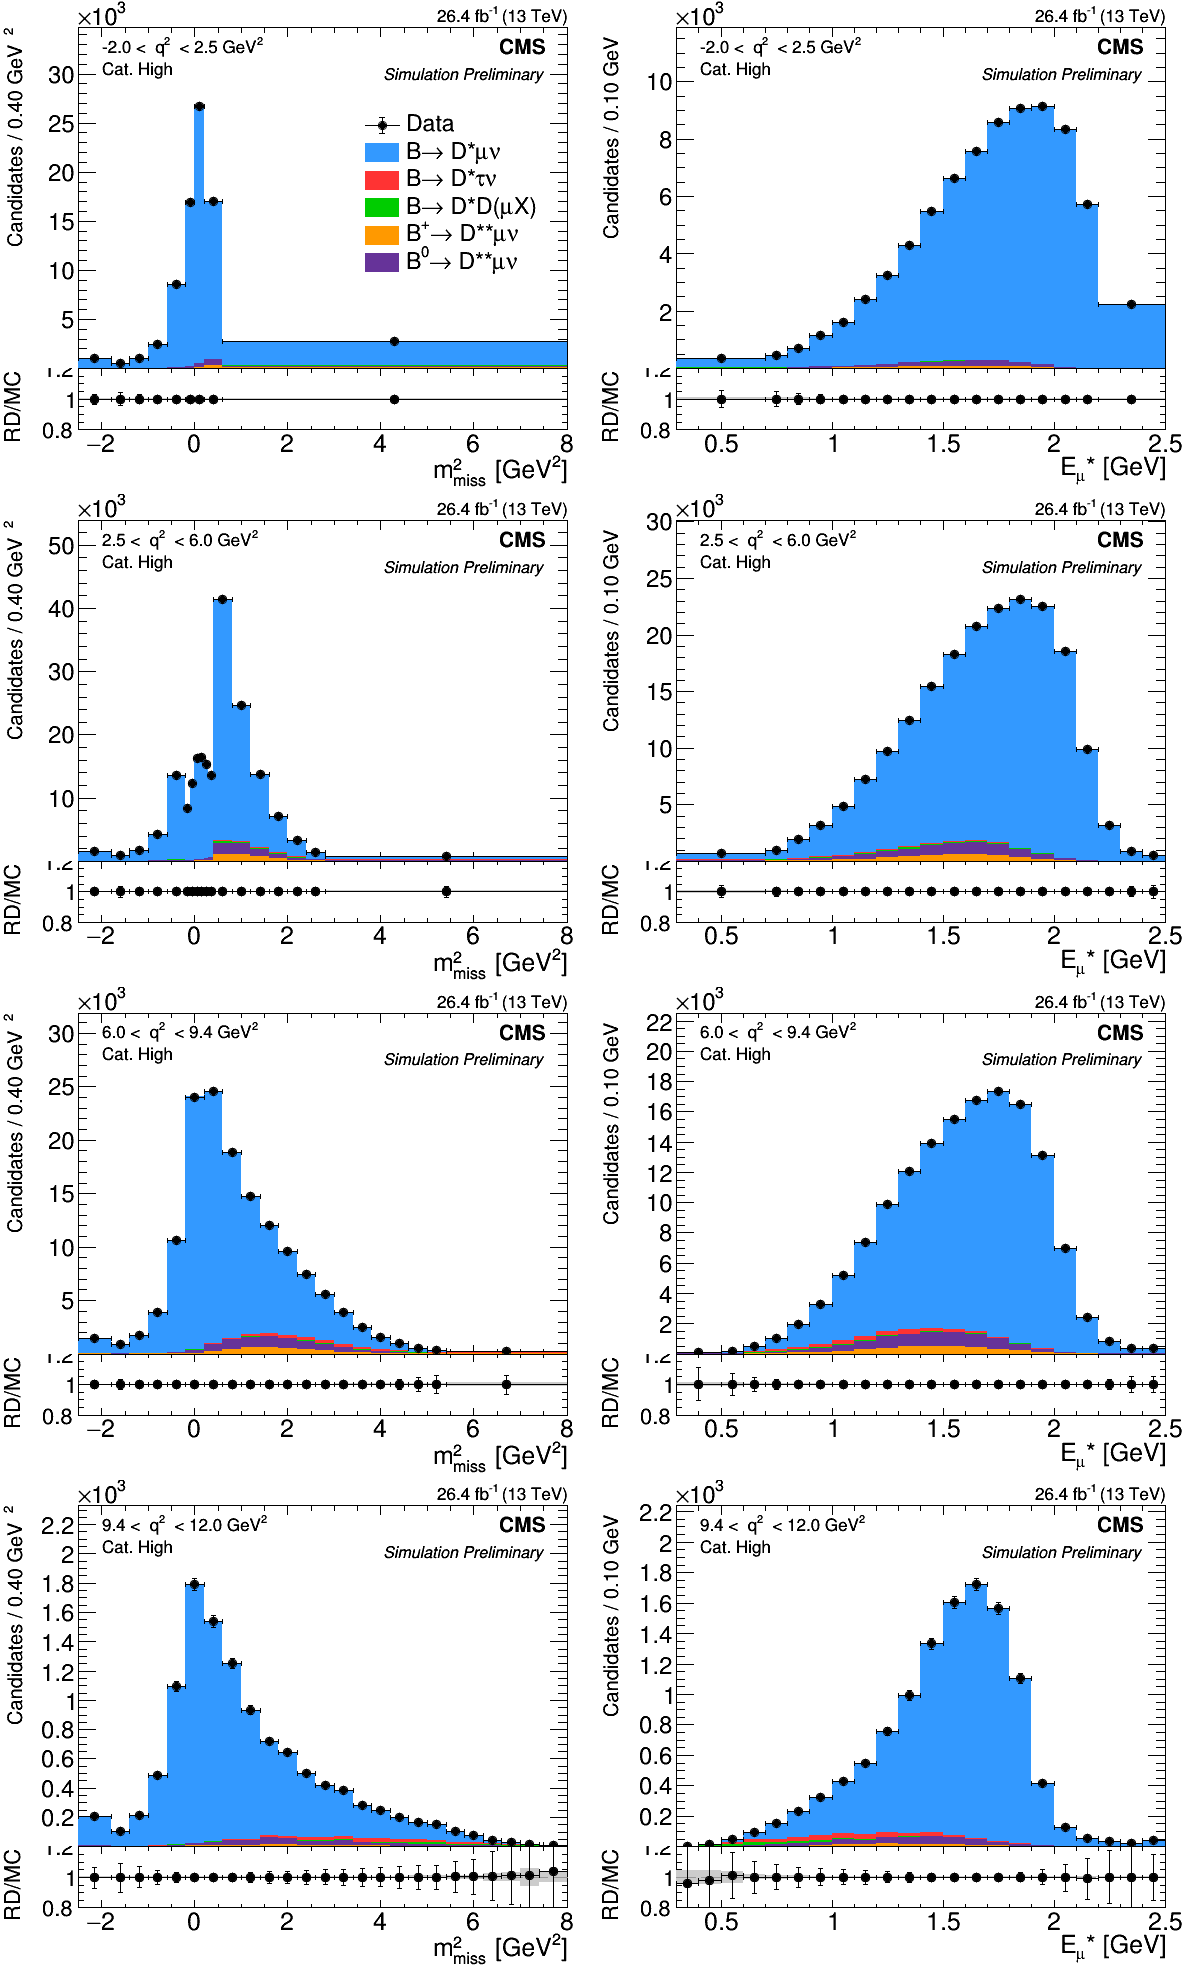

In [41]:
cSigPost = {}
for c in categoriesList:
    CMS_lumi.integrated_lumi = expectedLumi[c]
    cSigPost[c] = plot_gridVarQ2(CMS_lumi, binning, histo_postfit[c], iq2_maskData=[2, 3] if blinded_fit else [],
                                 draw_pulls=True, pullsRatio=True, categoryText=c.capitalize())
    n = outdir+'/fig/signalRegion_'+c+'_postfit'+ ('_RDstFixed' if forceRDst else '')+'.png'
    cSigPost[c].SaveAs(n)

In [42]:
if 'MVA' in histo_postfit['low'].keys():
    cMVAPost = {}
    for c in categoriesList:
        CMS_lumi.integrated_lumi = expectedLumi[c]        
        cMVAPost[c] = plot_SingleCategory(CMS_lumi, histo_postfit[c]['MVA'],
                                      addText='Cat. '+c.capitalize(), logy=True, legBkg=True,
                                      procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                      draw_pulls=True,
                                      min_y=1, tag=c+'MVA', legLoc=[0.25, 0.4, 0.5, 0.7])
        n = outdir+'/fig/MVA_'+c+'_postfit'+ ('_RDstFixed' if forceRDst else '')+'.png'
        cMVAPost[c].SaveAs(n)

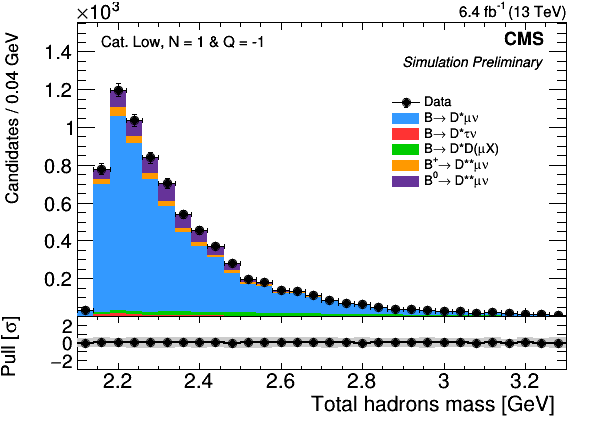

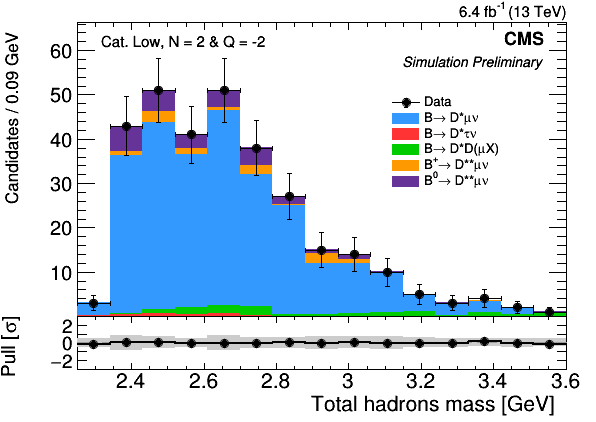

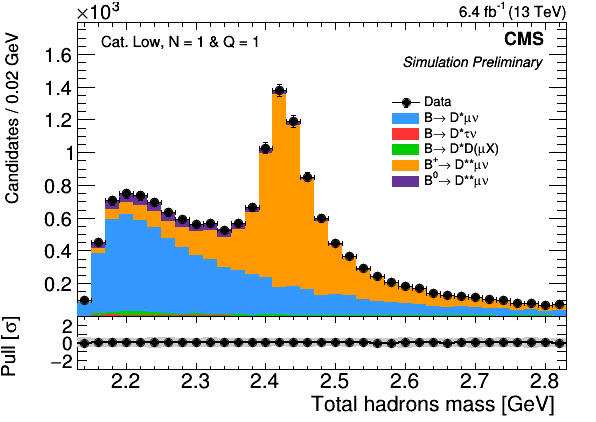

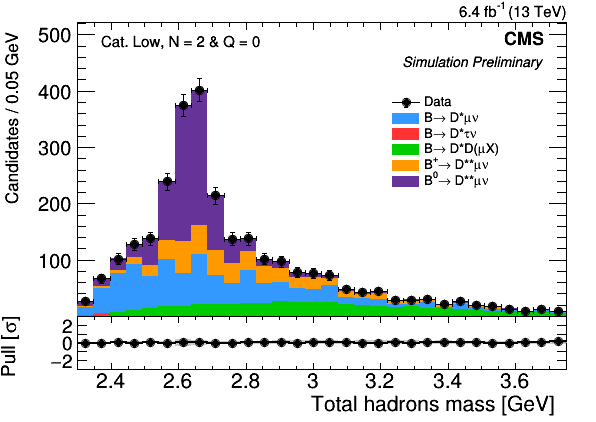

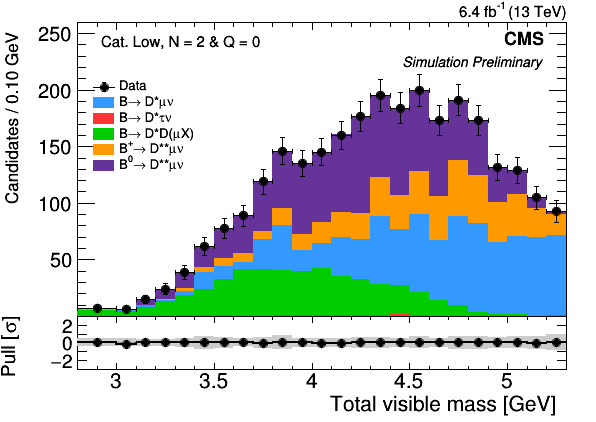

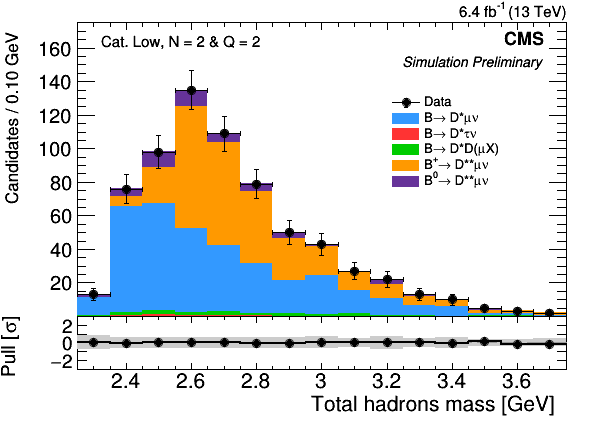

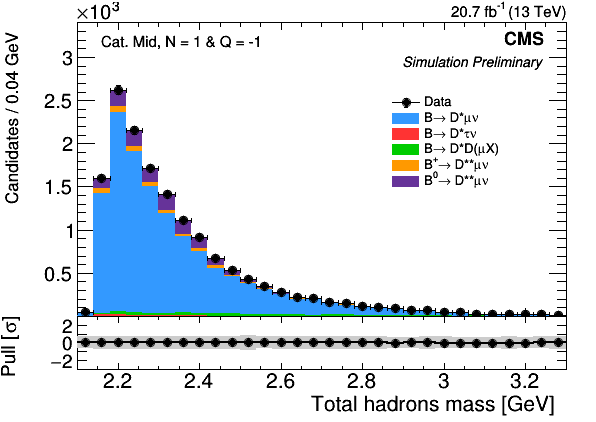

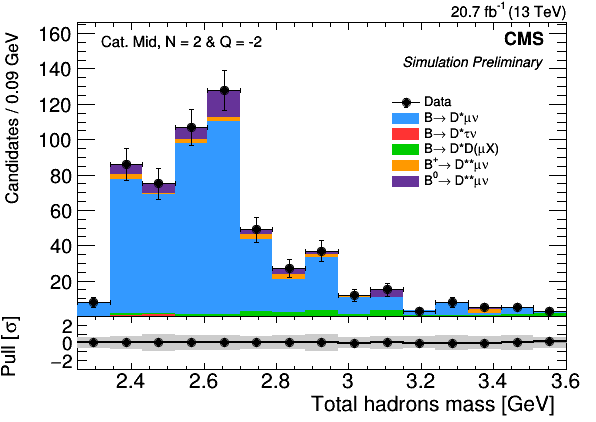

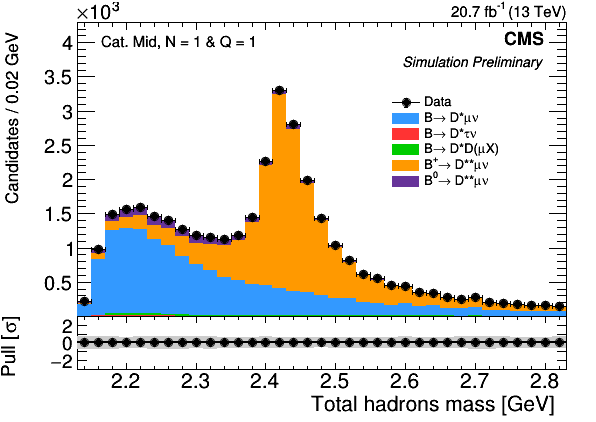

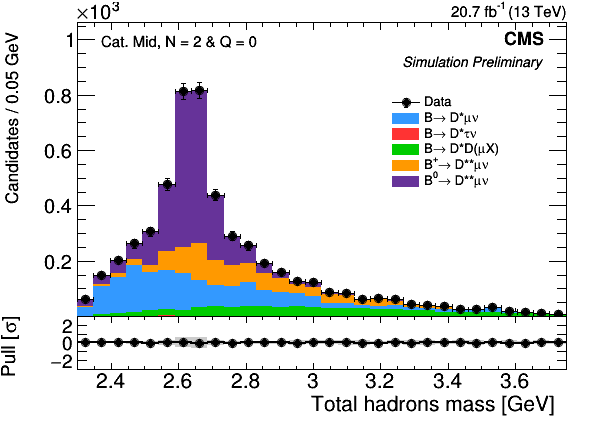

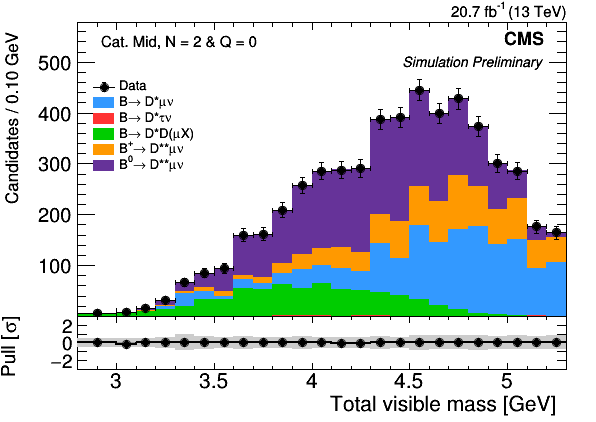

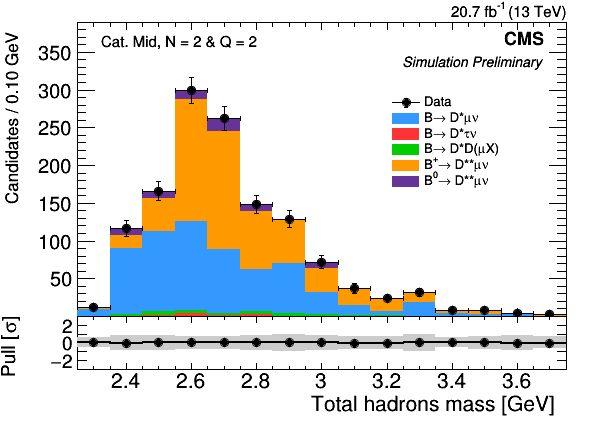

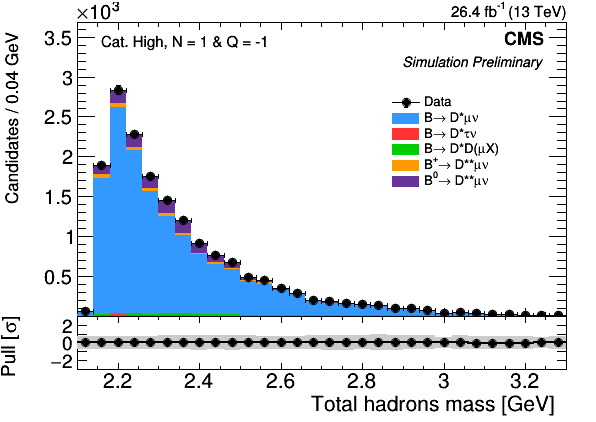

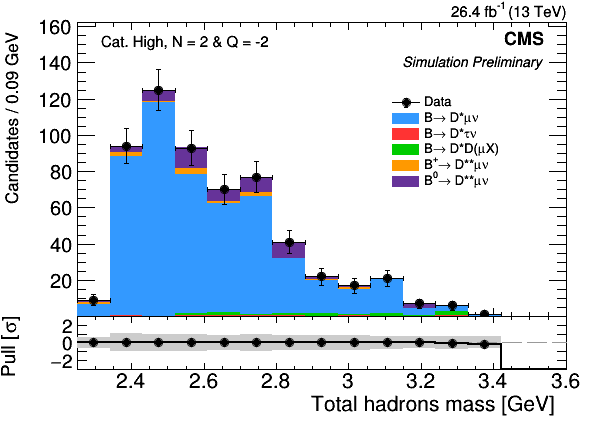

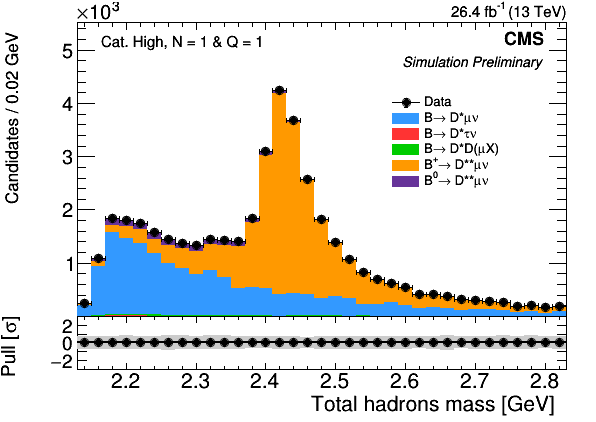

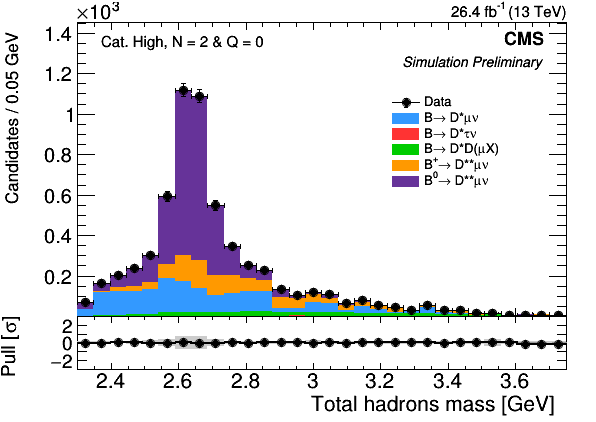

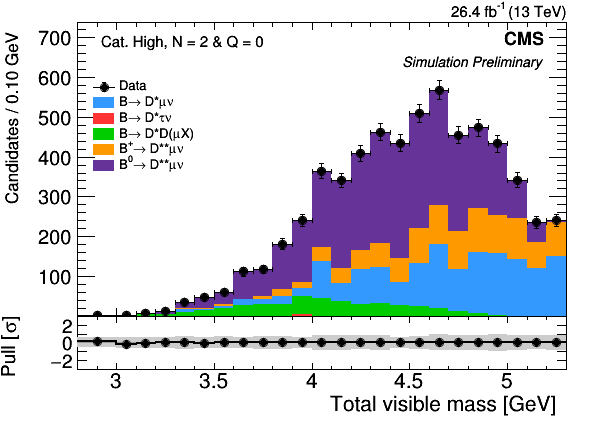

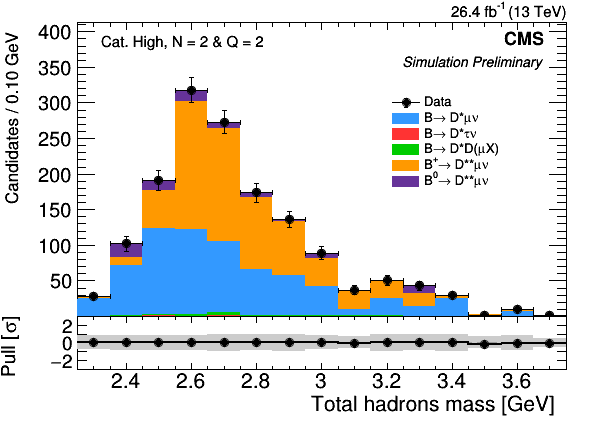

In [43]:
cSidePost = {}
for c in categoriesList:
    cSidePost[c] = {}
    CMS_lumi.integrated_lumi = expectedLumi[c]
    for k in np.sort([k for k in histo_postfit[c].keys() if k.startswith('Add')]):
        legLoc = [0.65, 0.4, 0.9, 0.7]
        if 'mVis' in k:
            legLoc = [0.15, 0.45, 0.35, 0.75]
        cSidePost[c][k] = plot_SingleCategory(CMS_lumi, histo_postfit[c][k],
                                              xtitle=getControlXtitle(k), 
                                              addText='Cat. '+c.capitalize() + ', ' + getControlSideText(k), 
                                              tag=c+k, legLoc=legLoc,
                                              draw_pulls=True
                                             )
        n = outdir+'/fig/'+k+'_'+c+'_postfit'+ ('_RDstFixed' if forceRDst else '')+'.png'
        cSidePost[c][k].SaveAs(n)   

In [48]:
cmd = 'python diffNuisances.py '.format(os.environ['CMSSW_BASE'])
cmd += outdir + '/fitDiagnostics{}.root'.format(card_name + ('_RDstFixed' if forceRDst else ''))
if not forceRDst:
    cmd += ' --skipFitB'
# cmd += ' --all'
cmd += ' --abs'
cmd += ' -g {}/nuisance_difference'.format(outdir) + ('_RDstFixed' if forceRDst else '') + '.root'
print cmd
status, output = commands.getstatusoutput(cmd)
if status:
    print output
    raise
dumpDiffNuisances(output, outdir, tag='RDstFixed' if forceRDst else '', useBonlyResults=forceRDst)

python diffNuisances.py results/v2combination_Asimov/fitDiagnosticsv2combination_Asimov.root --skipFitB --abs -g results/v2combination_Asimov/nuisance_difference.root
+-------------------------------------+------------------------+---------------------------------+
|              Parameter              |        pre-fit         |             post-fit            |
+-------------------------------------+------------------------+---------------------------------+
| prop_binhigh_AddTk_mm_mHad_bin12_mu | 1.000000 +/- 0.994425  | +0.83 +/- 0.64 (-0.17sig, 0.65) |
|   prop_binmid_AddTk_mm_mHad_bin14   | 0.000000 +/- 1.000000  | +0.15 +/- 0.76 (+0.15sig, 0.76) |
|   prop_binhigh_AddTk_pp_mHad_bin12  |  0.000000 +/- 1.000000 | -0.13 +/- 0.78 (-0.13sig, 0.78) |
|   prop_binhigh_AddTk_pm_mVis_bin1   | 0.000000 +/- 1.000000  | -0.12 +/- 0.82 (-0.12sig, 0.82) |
|   prop_binhigh_AddTk_pm_mVis_bin0   | 0.000000 +/- 1.000000  | +0.11 +/- 0.81 (+0.11sig, 0.81) |
|   prop_binlow_AddTk_pp_mHad_bin14   | 0

## Run likelyhood scan

combine -M MultiDimFit --algo grid --points=100 --robustFit 1 -d cards/v2combination_Asimov.root --X-rtd MINIMIZER_analytic --rMin=0.21 --rMax=0.38 -n v2combination_Asimov_nominal --setParameters r=0.29,mask_low_AddTk_pm_mHad=1,mask_low_Est_mu_q2bin0=1,mask_low_Est_mu_q2bin1=1,mask_low_Est_mu_q2bin2=1,mask_low_Est_mu_q2bin3=1,mask_low_M2_miss_q2bin0=1,mask_low_M2_miss_q2bin1=1,mask_low_M2_miss_q2bin2=1,mask_low_M2_miss_q2bin3=1,mask_mid_AddTk_pm_mHad=1,mask_mid_Est_mu_q2bin0=1,mask_mid_Est_mu_q2bin1=1,mask_mid_Est_mu_q2bin2=1,mask_mid_Est_mu_q2bin3=1,mask_mid_M2_miss_q2bin0=1,mask_mid_M2_miss_q2bin1=1,mask_mid_M2_miss_q2bin2=1,mask_mid_M2_miss_q2bin3=1,mask_high_AddTk_pm_mHad=1,mask_high_Est_mu_q2bin0=1,mask_high_Est_mu_q2bin1=1,mask_high_Est_mu_q2bin2=1,mask_high_Est_mu_q2bin3=1,mask_high_M2_miss_q2bin0=1,mask_high_M2_miss_q2bin1=1,mask_high_M2_miss_q2bin2=1,mask_high_M2_miss_q2bin3=1 --verbose -1
----------------------------------
R(D*) = 0.295 +0.029/-0.029 [9.9 %]
Sigma = 0.029
---

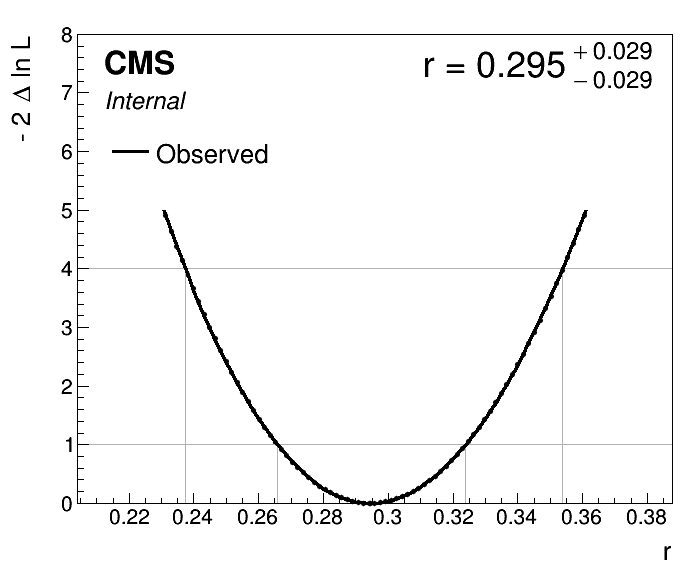

 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
Set Default Value of Parameter r To : 0.29
Set Default Value of Parameter mask_low_AddTk_pm_mHad To : 1
Set Default Value of Parameter mask_low_Est_mu_q2bin0 To : 1
Set Default Value of Parameter mask_low_Est_mu_q2bin1 To : 1
Set Default Value of Parameter mask_low_Est_mu_q2bin2 To : 1
Set Default Value of Parameter mask_low_Est_mu_q2bin3 To : 1
Set Default Value of Parameter mask_low_M2_miss_q2bin0 To : 1
Set Default Value of Parameter mask_low_M2_miss_q2bin1 To : 1
Set Default Value of Parameter mask_low_M2_miss_q2bin2 To : 1
Set Default Value of Parameter mask_low_M2_miss_q2bin3 To : 1
Set Default Value of Parameter mask_mid_AddTk_pm_mHad To : 1
Set Default Value of Parameter mask_mid_Est_mu_q2bin0 To : 1
Set Default Value of Parameter mask_mid_Est_mu_q2bin1 To : 1
Set Default Val

Info in <TCanvas::Print>: pdf file ./scan.pdf has been created
Info in <TCanvas::Print>: png file ./scan.png has been created


In [49]:
cmd = 'combine'
cmd += ' -M MultiDimFit'
cmd += ' --algo grid --points=100'
cmd += ' --robustFit 1'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --rMin={:.2f} --rMax={:.2f}'.format(*rDst_postFitRegion)
cmd += ' -n {}_nominal'.format(card_name)
cmd += ' --setParameters r={:.2f},{}'.format(fit_RDst, globalChannelMaskingStr)
cmd += ' --verbose -1'
print cmd
os.system(cmd)
cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += '; mv scan.png scan_nominal.png'
os.system(cmd)
res_nominal = getUncertaintyFromLimitTree('higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name))
rDst_postFitRegion = [res_nominal[0] - 2.2*res_nominal[1], res_nominal[0] + 2.2*res_nominal[2]]
display(Image(filename='scan_nominal.png'))

### Uncertainy breakdown by group

In [50]:
cmd = 'combine -M MultiDimFit --algo none'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' --setParameters r={:.2f},{}'.format(fit_RDst, globalChannelMaskingStr)
cmd += ' --setParameterRanges r=0.01,1'
cmd += ' -n {}_bestfit'.format(card_name)
cmd += ' --saveWorkspace --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo none --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic -d cards/v2combination_Asimov.root --setParameters r=0.29,mask_low_AddTk_pm_mHad=1,mask_low_Est_mu_q2bin0=1,mask_low_Est_mu_q2bin1=1,mask_low_Est_mu_q2bin2=1,mask_low_Est_mu_q2bin3=1,mask_low_M2_miss_q2bin0=1,mask_low_M2_miss_q2bin1=1,mask_low_M2_miss_q2bin2=1,mask_low_M2_miss_q2bin3=1,mask_mid_AddTk_pm_mHad=1,mask_mid_Est_mu_q2bin0=1,mask_mid_Est_mu_q2bin1=1,mask_mid_Est_mu_q2bin2=1,mask_mid_Est_mu_q2bin3=1,mask_mid_M2_miss_q2bin0=1,mask_mid_M2_miss_q2bin1=1,mask_mid_M2_miss_q2bin2=1,mask_mid_M2_miss_q2bin3=1,mask_high_AddTk_pm_mHad=1,mask_high_Est_mu_q2bin0=1,mask_high_Est_mu_q2bin1=1,mask_high_Est_mu_q2bin2=1,mask_high_Est_mu_q2bin3=1,mask_high_M2_miss_q2bin0=1,mask_high_M2_miss_q2bin1=1,mask_high_M2_miss_q2bin2=1,mask_high_M2_miss_q2bin3=1 --setParameterRanges r=0.01,1 -n v2combination_Asimov_bestfit --saveWorkspace --verbose -1
 <<< Combine >>> 
   Options for Robust Minimi

In [51]:
# Statistical uncertainty
cmd = 'combine -M MultiDimFit --algo grid --points=75'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(*rDst_postFitRegion)
cmd += ' --setParameters ' + globalChannelMaskingStr
cmd += ' -n {}_stat'.format(card_name)
cmd += ' --freezeParameters allConstrainedNuisances'
# cmd += ' --freezeNuisanceGroups=autoMCStats,allSys'
cmd += ' --fastScan' # To be added if there are no free parameters otherwise
cmd += ' --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo grid --points=75 --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic -d higgsCombinev2combination_Asimov_bestfit.MultiDimFit.mH120.root --snapshotName MultiDimFit --rMin=0.2311 --rMax=0.3592 --setParameters mask_low_AddTk_pm_mHad=1,mask_low_Est_mu_q2bin0=1,mask_low_Est_mu_q2bin1=1,mask_low_Est_mu_q2bin2=1,mask_low_Est_mu_q2bin3=1,mask_low_M2_miss_q2bin0=1,mask_low_M2_miss_q2bin1=1,mask_low_M2_miss_q2bin2=1,mask_low_M2_miss_q2bin3=1,mask_mid_AddTk_pm_mHad=1,mask_mid_Est_mu_q2bin0=1,mask_mid_Est_mu_q2bin1=1,mask_mid_Est_mu_q2bin2=1,mask_mid_Est_mu_q2bin3=1,mask_mid_M2_miss_q2bin0=1,mask_mid_M2_miss_q2bin1=1,mask_mid_M2_miss_q2bin2=1,mask_mid_M2_miss_q2bin3=1,mask_high_AddTk_pm_mHad=1,mask_high_Est_mu_q2bin0=1,mask_high_Est_mu_q2bin1=1,mask_high_Est_mu_q2bin2=1,mask_high_Est_mu_q2bin3=1,mask_high_M2_miss_q2bin0=1,mask_high_M2_miss_q2bin1=1,mask_high_M2_miss_q2bin2=1,mask_high_M2_miss_q2bin3=1 -n v2combination_Asimov_stat --freezeParamete

In [52]:
# MC Statistics
cmd = 'combine -M MultiDimFit --algo grid --points=75'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(*rDst_postFitRegion)
cmd += ' --setParameters ' + globalChannelMaskingStr
cmd += ' -n {}_MCstat'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --freezeNuisanceGroups=autoMCStats'
cmd += ' --verbose -1'
print cmd
os.system(cmd);

combine -M MultiDimFit --algo grid --points=75 --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic -d higgsCombinev2combination_Asimov_bestfit.MultiDimFit.mH120.root --rMin=0.2311 --rMax=0.3592 --setParameters mask_low_AddTk_pm_mHad=1,mask_low_Est_mu_q2bin0=1,mask_low_Est_mu_q2bin1=1,mask_low_Est_mu_q2bin2=1,mask_low_Est_mu_q2bin3=1,mask_low_M2_miss_q2bin0=1,mask_low_M2_miss_q2bin1=1,mask_low_M2_miss_q2bin2=1,mask_low_M2_miss_q2bin3=1,mask_mid_AddTk_pm_mHad=1,mask_mid_Est_mu_q2bin0=1,mask_mid_Est_mu_q2bin1=1,mask_mid_Est_mu_q2bin2=1,mask_mid_Est_mu_q2bin3=1,mask_mid_M2_miss_q2bin0=1,mask_mid_M2_miss_q2bin1=1,mask_mid_M2_miss_q2bin2=1,mask_mid_M2_miss_q2bin3=1,mask_high_AddTk_pm_mHad=1,mask_high_Est_mu_q2bin0=1,mask_high_Est_mu_q2bin1=1,mask_high_Est_mu_q2bin2=1,mask_high_Est_mu_q2bin3=1,mask_high_M2_miss_q2bin0=1,mask_high_M2_miss_q2bin1=1,mask_high_M2_miss_q2bin2=1,mask_high_M2_miss_q2bin3=1 -n v2combination_Asimov_MCstat --snapshotName MultiDimFit --freezeNuisan

plot1DScan.py higgsCombinev2combination_Asimov_nominal.MultiDimFit.mH120.root --main-label "Asimov" --others "higgsCombinev2combination_Asimov_MCstat.MultiDimFit.mH120.root:Stat. + Syst.:4" "higgsCombinev2combination_Asimov_stat.MultiDimFit.mH120.root:Stat. only:2" --breakdown "MC stat.,syst.,stat." --translate results/v2combination_Asimov/renameDicLikelihoodScan.json; mv scan.png scan_breakdown.png


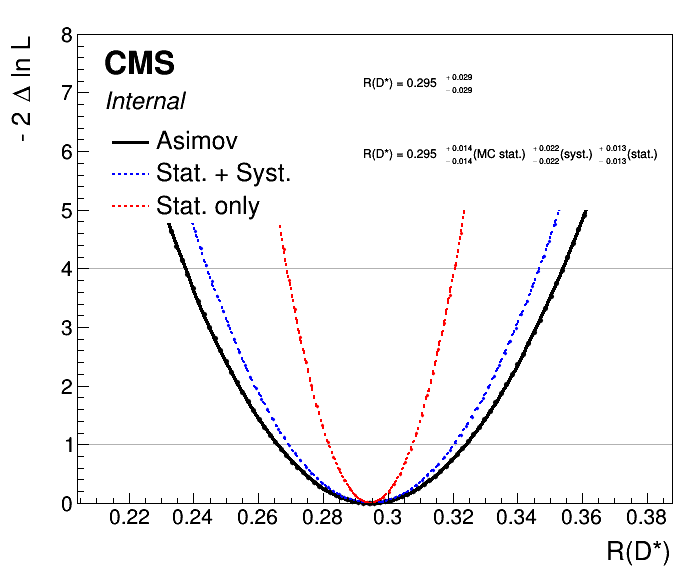

--------------------------------------
scan
--------------------------------------
[{'lo': 0.26576538034588626, 'hi': 0.3239814119411946, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.23731695300531602, 'hi': 0.35389676824436556, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.26927953439884644, 'hi': 0.3204410961734192, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.244301369676575, 'hi': 0.3467428899024883, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.28174163620183323, 'hi': 0.3075931610126267, 'valid_hi': True, 'valid_lo': True}]
[{'lo': 0.2688744563309267, 'hi': 0.32057729698822507, 'valid_hi': True, 'valid_lo': True}]


Info in <TCanvas::Print>: pdf file ./scan.pdf has been created
Info in <TCanvas::Print>: png file ./scan.png has been created


In [53]:
json.dump({'r': 'R(D*)'}, open(outdir+'/renameDicLikelihoodScan.json', 'w'))

cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --main-label "{}'.format('Obs.' if use_real_data else 'Asimov')
if blinded_fit: cmd += ' (blinded)'
cmd += '"'
cmd += ' --others'
cmd += ' "higgsCombine{}_MCstat.MultiDimFit.mH120.root:Stat. + Syst.:4"'.format(card_name)
cmd += ' "higgsCombine{}_stat.MultiDimFit.mH120.root:Stat. only:2"'.format(card_name)
cmd += ' --breakdown "MC stat.,syst.,stat."'
cmd += ' --translate ' + outdir+'/renameDicLikelihoodScan.json'
cmd += '; mv scan.png scan_breakdown.png'
print cmd
os.system(cmd)
display(Image(filename='scan_breakdown.png'))

In [54]:
os.system('mv higgsCombine{}_*.MultiDimFit.mH120.root '.format(card_name) + outdir + '/')
os.system('mv scan* ' + outdir + '/')
os.system('mv combine_logger.out ' + outdir + '/');

## Run the impact plots

In [55]:
if not runImpacts:
    raise

Fit first the POI

In [56]:
if os.path.isdir(outdir+'/impactPlots'):
    os.system('rm -rf '+outdir+'/impactPlots')
os.mkdir(outdir+'/impactPlots')

In [57]:
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts --doInitialFit -m 120'
cmd += ' --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' --setParameters r={:.2f},{}'.format(fit_RDst, globalChannelMaskingStr)
cmd += ' --setParameterRanges r={:.3f},{:.3f}'.format(*rDst_postFitRegion)
cmd += ' -n {}'.format(card_name)
cmd += ' --verbose -1'
os.system(cmd);

Have POIs: ['r']
 <<< Combine >>> 
   Options for Robust Minimizer :: 
        Tolerance  0.1
        Strategy   0
        Type,Algo  Minuit2,Migrad
>>> method used is MultiDimFit
>>> random number generator seed is 123456
Set Range of Parameter r To : (0.231,0.359)
Set Default Value of Parameter r To : 0.29
Set Default Value of Parameter mask_low_AddTk_pm_mHad To : 1
Set Default Value of Parameter mask_low_Est_mu_q2bin0 To : 1
Set Default Value of Parameter mask_low_Est_mu_q2bin1 To : 1
Set Default Value of Parameter mask_low_Est_mu_q2bin2 To : 1
Set Default Value of Parameter mask_low_Est_mu_q2bin3 To : 1
Set Default Value of Parameter mask_low_M2_miss_q2bin0 To : 1
Set Default Value of Parameter mask_low_M2_miss_q2bin1 To : 1
Set Default Value of Parameter mask_low_M2_miss_q2bin2 To : 1
Set Default Value of Parameter mask_low_M2_miss_q2bin3 To : 1
Set Default Value of Parameter mask_mid_AddTk_pm_mHad To : 1
Set Default Value of Parameter mask_mid_Est_mu_q2bin0 To : 1
Set Default Val

 Perform a similar scan for each nuisance parameter

If running on Tier2 condor remmeber to add this line to CombineToolBase.py ln 11
``source /cvmfs/cms.cern.ch/cmsset_default.sh``

In [58]:
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts --doFits -m 120'
cmd += ' --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' --setParameters r={:.2f},{}'.format(fit_RDst, globalChannelMaskingStr)
cmd += ' --setParameterRanges r={:.3f},{:.3f}'.format(*rDst_postFitRegion)
cmd += ' --parallel 100 --job-mode condor --task-name combineImpacts_combination'
cmd += ' --sub-opts "{}"'.format(stringJubCustomizationCaltechT2.replace('"', '\\\"').replace('$', '\$'))
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' -n {}'.format(card_name)
cmd += ' --verbose -1'
print cmd
os.system(cmd);

cd results/v2combination_Asimov/impactPlots; combineTool.py -M Impacts --doFits -m 120 --robustFit 1 --X-rtd MINIMIZER_analytic --setParameters r=0.29,mask_low_AddTk_pm_mHad=1,mask_low_Est_mu_q2bin0=1,mask_low_Est_mu_q2bin1=1,mask_low_Est_mu_q2bin2=1,mask_low_Est_mu_q2bin3=1,mask_low_M2_miss_q2bin0=1,mask_low_M2_miss_q2bin1=1,mask_low_M2_miss_q2bin2=1,mask_low_M2_miss_q2bin3=1,mask_mid_AddTk_pm_mHad=1,mask_mid_Est_mu_q2bin0=1,mask_mid_Est_mu_q2bin1=1,mask_mid_Est_mu_q2bin2=1,mask_mid_Est_mu_q2bin3=1,mask_mid_M2_miss_q2bin0=1,mask_mid_M2_miss_q2bin1=1,mask_mid_M2_miss_q2bin2=1,mask_mid_M2_miss_q2bin3=1,mask_high_AddTk_pm_mHad=1,mask_high_Est_mu_q2bin0=1,mask_high_Est_mu_q2bin1=1,mask_high_Est_mu_q2bin2=1,mask_high_Est_mu_q2bin3=1,mask_high_M2_miss_q2bin0=1,mask_high_M2_miss_q2bin1=1,mask_high_M2_miss_q2bin2=1,mask_high_M2_miss_q2bin3=1 --setParameterRanges r=0.231,0.359 --parallel 100 --job-mode condor --task-name combineImpacts_combination --sub-opts "
+RunAsOwner = True
+InteractiveUs

Collect the results

In [59]:
status, output = commands.getstatusoutput('condor_q')
while 'combineImpacts_combination' in output:
    time.sleep(20)
    status, output = commands.getstatusoutput('condor_q')
    for l in output.split('\n'):
        if 'combineImpacts_combination' in l: 
            print l
            sys.stdout.flush()
cmd = 'cd {}/impactPlots;'.format(outdir)
cmd += ' combineTool.py -M Impacts -o impacts.json -m 120'
cmd += ' -d ../../../' + card_location.replace('.txt', '.root')
cmd += ' -n {}'.format(card_name)
print cmd
os.system(cmd);

ocerri combineImpacts_combination  10/9  17:50      _    776    292   1068 205863.0-1067
ocerri combineImpacts_combination  10/9  17:50      _    776    292   1068 205863.0-1067
ocerri combineImpacts_combination  10/9  17:50      1    776    291   1068 205863.0-1067
ocerri combineImpacts_combination  10/9  17:50     11    776    281   1068 205863.0-1067
ocerri combineImpacts_combination  10/9  17:50    158    776    134   1068 205863.0-1067
ocerri combineImpacts_combination  10/9  17:50    512    555      _   1068 205863.1-1067
ocerri combineImpacts_combination  10/9  17:50    794    274      _   1068 205863.16-1067
ocerri combineImpacts_combination  10/9  17:50    952    116      _   1068 205863.38-1067
ocerri combineImpacts_combination  10/9  17:50   1014     54      _   1068 205863.38-1063
ocerri combineImpacts_combination  10/9  17:50   1057     11      _   1068 205863.38-982
cd results/v2combination_Asimov/impactPlots; combineTool.py -M Impacts -o impacts.json -m 120 -d ../../../c

In [60]:
rename = {
'r': 'R(D*)',
'B0pT': 'B_{0} p_{T} spectrum',
'B2DstCLNR0':'R_{0} (CLN B#rightarrow D*#ell#nu)',
'B2DstCLNeig1':'#lambda_{1} (CLN B#rightarrow D*l#nu)',
'B2DstCLNeig2':'#lambda_{2} (CLN B#rightarrow D*l#nu)',
'B2DstCLNeig3':'#lambda_{3} (CLN B#rightarrow D*l#nu)',
# 'B2DstCLNR1':'R_{1} (CLN B#rightarrow D*)',
# 'B2DstCLNR2':'R_{2} (CLN B#rightarrow D*)',
# 'B2DstCLNRhoSq':'#rho^{2} (CLN B#rightarrow D*)',
'trgSF': 'Trigger scale factor',
'xsecpp2bbXlumi': 'Luminosity*#sigma_{pp#rightarrowbb}',
    
}

procName_dic = {
'mu'        : 'B_{0}#rightarrow D*#mu#nu',
'tau'       : 'B_{0}#rightarrow D*#tau#nu',
'DstmD0'    : 'B^{+}#rightarrow D*D_{0}(#muY) + X',
'DstmDp'    : 'B^{+}#rightarrow D*D^{+}(#muY) + X',
'DstmDsp'   : 'B^{+}#rightarrow D*D_{s}^{+}(#muX)',
'DstPip'    : 'B^{+}#rightarrow D*#pi^{+}#mu#nu',
'DstPipPi0' : 'B^{+}#rightarrow D*#pi^{+}#pi^{0}#mu#nu',
'DstPi0'    : 'B_{0}#rightarrow D*#pi^{0}#mu#nu',
'DstPipPim' : 'B_{0}#rightarrow D*#pi^{+}#pi^{-}#mu#nu',
'DstPi0Pi0' : 'B_{0}#rightarrow D*#pi^{0}#pi^{0}#mu#nu',
'BpDstmHc'  : 'B^{+}#rightarrow D*D(#muX)',
'BmDstmHc'  : 'B^{-}#rightarrow D*D(#muX)',
'antiB0DstmHc'  : '#bar{B}_{0}#rightarrow D*D(#muX)',
'DstPi'     : 'B #rightarrow D**(#rightarrow D*#pi)#mu#nu',
'DstPiPi'   : 'B #rightarrow D**(#rightarrow D*#pi#pi)#mu#nu', 
}

for n in procName_dic:
    rename[n+'Br'] = 'Branching fraction ' + procName_dic[n]

d = json.load(open(outdir+'/impactPlots/impacts.json', 'r'))
for par in d['params']:
    name = str(par['name'])
    if not name.startswith('prop_bin'): continue
    label = name.replace('prop_bin', 'MC stat. ')
    label = label.replace('M2_miss_', 'M^{2}_{miss} ')
    label = label.replace('Est_mu_', 'E*_{#mu} ')
    label = label.replace('q2bin', '[b_{q^{2}}=')
    label = label.replace('_bin', '] ')
    rename[name] = label + 10*' '
    
json.dump(rename, open(outdir+'/impactPlots/rename.json', 'w'))

cmd = 'cd {};'.format(outdir)
cmd += 'plotImpacts.py -i impactPlots/impacts.json -o impacts -t impactPlots/rename.json'
os.system(cmd)
IFrame(outdir+'/impacts.pdf', width=900, height=600)

>> Doing page 0, have 30 parameters
>> Doing page 1, have 30 parameters
>> Doing page 2, have 30 parameters
>> Doing page 3, have 30 parameters
>> Doing page 4, have 30 parameters
>> Doing page 5, have 30 parameters
>> Doing page 6, have 30 parameters
>> Doing page 7, have 30 parameters
>> Doing page 8, have 30 parameters
>> Doing page 9, have 30 parameters
>> Doing page 10, have 30 parameters
>> Doing page 11, have 30 parameters
>> Doing page 12, have 30 parameters
>> Doing page 13, have 30 parameters
>> Doing page 14, have 30 parameters
>> Doing page 15, have 30 parameters
>> Doing page 16, have 30 parameters
>> Doing page 17, have 30 parameters
>> Doing page 18, have 30 parameters
>> Doing page 19, have 30 parameters
>> Doing page 20, have 30 parameters
>> Doing page 21, have 30 parameters
>> Doing page 22, have 30 parameters
>> Doing page 23, have 30 parameters
>> Doing page 24, have 30 parameters
>> Doing page 25, have 30 parameters
>> Doing page 26, have 30 parameters
>> Doing pa

Info in <TCanvas::Print>: pdf file ./impacts.pdf has been created using the current canvas
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./impacts.pdf
TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: impacts
Info in <TCanvas::Print>: Current canvas added to pdf file ./imp

## Run the Goodness of fit test

In [ ]:
GoF_AdditionalChannelMasking = [
#     'AddTk_p_mHad',
#     'AddTk_m_mHad',
#     'AddTk_pm_mVis',
#     'AddTk_pp_mHad',
#     'AddTk_mm_mHad',
#     'Unrolled_q2bin0',
#     'Unrolled_q2bin1',
#     'Unrolled_q2bin2',
#     'Unrolled_q2bin3', 
#     'MVA'
]

maskGoF = globalChannelMaskingStr
for c in categoriesList:
    for cm in GoF_AdditionalChannelMasking:
        maskGoF += ',mask_{}_{}=1'.format(c, cm)

tag = '_All'
# tag = '_SignalRegionOnly'
# tag = '_ControlRegionOnly'
# tag = '_N2ControlRegionsOnly'
# tag = '_AddTk_pp_mHad_Only'

algo = ['Sat', 'AD', 'KS'][2]
fixRDst = True
fitRegionsOnly = True

tag += '_algo'+algo
if fixRDst:
    tag += '_fixRDst'
if fitRegionsOnly or algo!='Sat':
    tag += '_fitRegionsOnly'
    
os.system('rm -rf *.GoodnessOfFit.*.root')
print tag

Run the observed test stat value

In [ ]:
cmd = 'combine -M GoodnessOfFit'
cmd += ' --algo=saturated  --toysFrequentist' if algo=='Sat' else ' --algo='+algo
cmd += ' --X-rtd MINIMIZER_analytic'
if not fitRegionsOnly:
    cmd += ' --setParametersForFit ' + globalChannelMaskingStr
    cmd += ' --setParametersForEval ' + maskGoF
if fixRDst or fitRegionsOnly:
    aux = card_location.replace('.txt', '.root')
    if fitRegionsOnly:
        aux = aux.replace('.root', '_fitRegionsOnly.root')
    cmd += ' -d ' + aux
    cmd += ' --freezeParameters r --setParameters r={:.3f}'.format(SM_RDst)
    
else:
    cmd += ' -d results/{cn}/higgsCombine{cn}_bestfit.MultiDimFit.mH120.root'.format(cn=card_name)
    cmd += ' --snapshotName MultiDimFit'
cmd += ' -n Obs'+tag
cmd += ' -t 0 -s 100'
cmd += ' --verbose 1'
print cmd
os.system(cmd)
# status, output = commands.getstatusoutput(cmd)
# print output

Run the test stat toy distribution

In [ ]:
cmdToys = cmd.replace('-n Obs', '-n Toys')
cmdToys = cmdToys.replace('-t 0 -s 100', '-t 10 -s -1')
print cmdToys

In [ ]:
from multiprocessing import Pool

def runCommand(cmd):
    os.system(cmd)

Nrep = 15
p = Pool(min(20,Nrep))
outputs = p.map(runCommand, Nrep*[cmdToys])

In [ ]:
gofOutdir = outdir + '/goodnessOfFit'+tag
if not os.path.isdir(gofOutdir):
    os.system('mkdir ' + gofOutdir)
os.system('mv *{}.GoodnessOfFit.*.root {}/'.format(tag, gofOutdir));

Combine them to get the p-value

In [ ]:
f = ur.open(gofOutdir+'/higgsCombineObs'+tag+'.GoodnessOfFit.mH120.100.root')
s_obs = f['limit']['limit'].array()[0]

s_toys = []
for name_toys in glob(gofOutdir+'/higgsCombineToys'+tag+'.GoodnessOfFit.*.root'):
    f = ur.open(name_toys)
    s_toys += list(f['limit']['limit'].array())
p_val = np.sum(s_toys > s_obs)/float(len(s_toys))
    
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8,6))
content, center, _ = plt.hist(s_toys, weights=np.ones_like(s_toys)/float(len(s_toys)), 
                              alpha=0.7, label='Toys ({:.0f})'.format(float(len(s_toys))))
plt.plot([s_obs, s_obs], [0, np.max(content)], 'm--', label='Observed\np-val {:.1f}%'.format(100*p_val))
plt.legend(loc='upper right')
plt.xlabel('Test statistic')
plt.ylabel('Probability / {:.1f}'.format(0.5*(center[2]-center[1])))
plt.savefig(outdir + '/fig/GoF_results'+tag+'.png')

In [ ]:
strRes = tag[1:]
strRes += ' '*(55-len(strRes))
strRes += '{:.1f}'.format(s_obs)
strRes += ' '*(70-len(strRes))
strRes += '{:.1f}\t{:.1f}'.format(np.percentile(s_toys, 50), np.percentile(s_toys, 95))
os.system('echo "{}" >> {}/GoF_results.txt'.format(strRes, outdir));

# The End

In [ ]:
print 'done'